In [1]:
import os
import yaml
import urllib
from PIL import Image
from enum import Enum
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import xml.etree.cElementTree as ET
import glob
import argparse
import numpy as np
import json
import numpy
import cv2
from collections import OrderedDict
import scipy.misc
from skimage import measure   
import random
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import shutil
import pickle
import pandas as pd

WORKING_DIRECTORY = '/media/dean/datastore1/datasets/darknet_evaluate'
COCO_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'data', 'coco')
BDD10K_COCO_ANNOTATIONS_FILE = os.path.join(COCO_DIRECTORY,'annotations' , 'bdd10k_instances_val2014.json')
IMAGES_DIRECTORY = os.path.join(COCO_DIRECTORY, 'images','train2014')
WEIGHTS_DIRECTORY = os.path.join(WORKING_DIRECTORY,'trained_weights')
LABELS_DIRECTORY = os.path.join(COCO_DIRECTORY, 'labels','train2014')
CATEGORY_NAMES = os.path.join(WORKING_DIRECTORY, 'data', 'coco.bdd100k.names')

In [2]:
bdd10k_coco = COCO(BDD10K_COCO_ANNOTATIONS_FILE)
ann_ids = bdd10k_coco.getAnnIds()
print(len(ann_ids))

loading annotations into memory...
Done (t=1.00s)
creating index...
index created!
185526


In [3]:
# For Run in Training Runs    
training_runs = os.listdir(os.path.join(WEIGHTS_DIRECTORY,'training_runs'))
all_runs = []
#for run in [training_runs[1]]:
for run in training_runs:
    print('Evaluating mAP on Training Run:', os.path.join(WEIGHTS_DIRECTORY,'training_runs',run))
    # Grab iterations and sort checkpoints
    d = {}
    weights_files = glob.glob(os.path.join(WEIGHTS_DIRECTORY,'training_runs',run, '*.weights'))
    
    for fpath in weights_files:
        fname = os.path.split(fpath)[-1]
        iterations = fname[15:].split('.weights')[0]
        if iterations != 'final':
            d[fname] = int(iterations)
        else:
            d[fname] = 100000
    sorted_weights = OrderedDict(sorted(d.items(), key=lambda kv: kv[1]))
    bdd_weights = OrderedDict()

    for weights_file in sorted_weights.keys():
        d = {}
        d['iterations'] = sorted_weights[weights_file]
        d['map_results_file'] = os.path.join(WEIGHTS_DIRECTORY, 'training_runs',run, weights_file+'.txt')
        map_results_file = d['map_results_file']
        d['map_results_file'] = d['map_results_file'] +'.backup'

        if not os.path.exists(d['map_results_file']):
            # Create annotations if labels directory not found
            if not os.path.exists(os.path.join(COCO_DIRECTORY,'labels/train2014/manifast.txt')):
                #!java -jar $WORKING_DIRECTORY/data/cocotoyolo.jar "{BDD10K_COCO_ANNOTATIONS_FILE}" "{IMAGES_DIRECTORY}/" "all" "{COCO_DIRECTORY}/labels/train2014"
                yolo_convert_output = os.path.join(COCO_DIRECTORY, 'labels','convert2yolo_results.txt')
                !python3 $WORKING_DIRECTORY/convert2Yolo/example.py --datasets COCO --img_path "{IMAGES_DIRECTORY}" --label "{BDD10K_COCO_ANNOTATIONS_FILE}" --convert_output_path "{LABELS_DIRECTORY}" --img_type ".jpg" --manipast_path $LABELS_DIRECTORY --cls_list_file $CATEGORY_NAMES | tee -a $yolo_convert_output
                
            CURRENT_WEIGHT = os.path.join(WEIGHTS_DIRECTORY, 'training_runs',run, weights_file)
            outfile = !cd $WORKING_DIRECTORY && ./darknet detector map cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT | tee -a $map_results_file
            with open(d['map_results_file'],"w+") as f:
                outfile = '\n'.join(outfile)
                f.write(outfile)

        #Get mAP results from file
        class_stats = []
        map_stats = {}
        with open(d['map_results_file']) as openfile:
            for line in openfile:
                for part in line.split():
                    if 'class_id' in part:
                        class_map = {}
                        if 'class_id =' in line:
                            id_tokens = line.split('class_id =')[1].split(',')
                            if id_tokens[0] in [str(i) for i in range(10)]: 
                                class_map['class_id'] = int(id_tokens[0].strip())
                        
                        if 'name =' in line:
                            name_tokens = line.split('name =')[1].split(',')
                            class_map['class_name'] = name_tokens[0].strip()

                        if 'ap =' in line:
                            ap_tokens = line.split('ap =')[1].split(',')
                            class_map['class_ap'] = ap_tokens[0].split('%')[0].strip()

                        class_stats.append(class_map)
                    elif '(mAP)' in part:
                        tokens = line.split('(mAP) =')[1]
                        map_stats['mean_avg_precision'] = tokens.split()[2].strip(',')
                    elif 'Detection' in part:
                        tokens = line.split(':')[1]
                        total_detection_time = str(''.join(tokens)).strip()
                        map_stats['total_detection_time'] = total_detection_time
                    elif 'average IoU' and  'average IoU =' in line:
                        tokens = line.split('average IoU =')[1].split(',')
                        map_stats['avg_IoU'] = tokens[0].split('%')[0].strip()
                
        map_stats['weights'] = d
        map_stats['class_stats'] = class_stats
        print(map_stats,'\n\n') 
        bdd_weights[weights_file] = map_stats

    # Make sure Dictionary is made properly
    all_runs.append((run, bdd_weights))

# Cache Data    
pickle_file = os.path.join(COCO_DIRECTORY, 'mAP_all_runs.pickle')
pickle_dict = {'all_runs': all_runs}
with open(pickle_file,"wb") as pickle_out:
    pickle.dump(pickle_dict, pickle_out)   

Evaluating mAP on Training Run: /media/dean/datastore1/datasets/darknet_evaluate/trained_weights/training_runs/run5_multi_gpu_lr0005_128bacth
{'total_detection_time': '299.000000 Seconds', 'avg_IoU': '34.65', 'mean_avg_precision': '26.72', 'weights': {'iterations': 2188, 'map_results_file': '/media/dean/datastore1/datasets/darknet_evaluate/trained_weights/training_runs/run5_multi_gpu_lr0005_128bacth/yolov3-bdd100k_2188.weights.txt.backup'}, 'class_stats': [{'class_name': 'person', 'class_ap': '28.94'}, {'class_name': 'rider', 'class_ap': '18.43'}, {'class_name': 'car', 'class_ap': '55.81'}, {'class_name': 'truck', 'class_ap': '39.65'}, {'class_name': 'bus', 'class_ap': '33.61'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'motor', 'class_ap': '13.79'}, {'class_name': 'bike', 'class_ap': '16.89'}, {'class_name': 'traffic sign', 'class_ap': '34.29'}, {'class_name': 'traffic light', 'class_ap': '25.78'}]} 


{'total_detection_time': '303.000000 Seconds', 'avg_IoU': '40.95'

In [4]:
print(len(bdd_weights))

6


## Plot Metrics


In [13]:
bdd_data = []
for run, bdd_weights in all_runs:
    for weights, map_stats in bdd_weights.items():
        d = {}
        d['training_run'] = run
        d['map_results_file'] = map_stats['weights']['map_results_file']
        d['iterations'] = map_stats['weights']['iterations']
        d['mean_avg_precision'] = map_stats['mean_avg_precision']
        d['person_ap'], d['rider_ap'], d['car_ap'], d['truck_ap'], d['bus_ap'], d['train_ap'], d['motor_ap'], d['bike_ap'], d['traffic_sign_ap'], d['traffic_light_ap'] = [0.0]*10
        
                    
        for cls in map_stats['class_stats']:
            cls_name = cls.get('class_name', '').strip()
            if cls_name == 'person':
                d['person_ap'] = cls['class_ap']
            elif cls_name == 'rider':
                d['rider_ap'] = cls['class_ap']
            elif cls_name == 'car':
                d['car_ap'] = cls['class_ap']
            elif cls_name == 'truck':
                d['truck_ap'] = cls['class_ap']
            elif cls_name == 'bus':
                d['bus_ap'] = cls['class_ap']
            elif cls_name == 'train':
                d['train_ap'] = cls['class_ap']
            elif cls_name == 'motor':
                d['motor_ap'] = cls['class_ap']
            elif cls_name == 'bike':
                d['bike_ap'] = cls['class_ap']
            elif cls_name == 'traffic sign':
                d['traffic_sign_ap'] = cls['class_ap']
            elif cls_name == 'traffic light':
                d['traffic_light_ap'] = cls['class_ap']
        d['total_detection_time'] = map_stats['total_detection_time']
        d['avg_IoU'] = map_stats.get('avg_IoU','')
        bdd_data.append(d)
data = pd.DataFrame(bdd_data)
data = data.apply(pd.to_numeric, errors='ignore')
data.head(100)

,avg_IoU,bike_ap,bus_ap,car_ap,iterations,map_results_file,mean_avg_precision,motor_ap,person_ap,rider_ap,total_detection_time,traffic_light_ap,traffic_sign_ap,train_ap,training_run,truck_ap
0,34.65,16.89,33.61,55.81,2188,/media/dean/datastore1/datasets/darknet_evalua...,26.72,13.79,28.94,18.43,299.000000 Seconds,25.78,34.29,0.0,run5_multi_gpu_lr0005_128bacth,39.65
1,40.95,24.58,43.30,61.23,5470,/media/dean/datastore1/datasets/darknet_evalua...,33.68,20.36,34.01,27.16,303.000000 Seconds,28.32,49.29,0.0,run5_multi_gpu_lr0005_128bacth,48.58
2,46.81,30.20,49.09,62.99,9846,/media/dean/datastore1/datasets/darknet_evalua...,38.16,23.11,38.32,29.61,293.000000 Seconds,42.45,54.95,0.0,run5_multi_gpu_lr0005_128bacth,50.89
3,45.89,30.40,48.42,62.96,10940,/media/dean/datastore1/datasets/darknet_evalua...,38.68,26.44,39.18,32.99,291.000000 Seconds,39.56,54.89,0.0,run5_multi_gpu_lr0005_128bacth,51.97
4,49.55,34.18,53.23,64.86,19692,/media/dean/datastore1/datasets/darknet_evalua...,41.34,29.37,43.06,34.38,287.000000 Seconds,41.46,57.05,0.0,run5_multi_gpu_lr0005_128bacth,55.81
5,45.96,34.38,55.01,64.55,22974,/media/dean/datastore1/datasets/darknet_evalua...,40.94,29.45,42.84,33.99,284.000000 Seconds,41.02,54.45,0.0,run5_multi_gpu_lr0005_128bacth,53.75


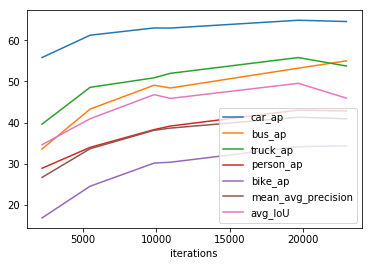

In [14]:
%matplotlib inline 
data.plot(x='iterations',y=['car_ap', 'bus_ap', 'truck_ap', 'person_ap', 'bike_ap', 'mean_avg_precision', 'avg_IoU'])
plt.show()

In [15]:
df = data.sort_values(by=['avg_IoU'], ascending = False)
df.head(10)

,avg_IoU,bike_ap,bus_ap,car_ap,iterations,map_results_file,mean_avg_precision,motor_ap,person_ap,rider_ap,total_detection_time,traffic_light_ap,traffic_sign_ap,train_ap,training_run,truck_ap
4,49.55,34.18,53.23,64.86,19692,/media/dean/datastore1/datasets/darknet_evalua...,41.34,29.37,43.06,34.38,287.000000 Seconds,41.46,57.05,0.0,run5_multi_gpu_lr0005_128bacth,55.81
2,46.81,30.20,49.09,62.99,9846,/media/dean/datastore1/datasets/darknet_evalua...,38.16,23.11,38.32,29.61,293.000000 Seconds,42.45,54.95,0.0,run5_multi_gpu_lr0005_128bacth,50.89
5,45.96,34.38,55.01,64.55,22974,/media/dean/datastore1/datasets/darknet_evalua...,40.94,29.45,42.84,33.99,284.000000 Seconds,41.02,54.45,0.0,run5_multi_gpu_lr0005_128bacth,53.75
3,45.89,30.40,48.42,62.96,10940,/media/dean/datastore1/datasets/darknet_evalua...,38.68,26.44,39.18,32.99,291.000000 Seconds,39.56,54.89,0.0,run5_multi_gpu_lr0005_128bacth,51.97
1,40.95,24.58,43.30,61.23,5470,/media/dean/datastore1/datasets/darknet_evalua...,33.68,20.36,34.01,27.16,303.000000 Seconds,28.32,49.29,0.0,run5_multi_gpu_lr0005_128bacth,48.58
0,34.65,16.89,33.61,55.81,2188,/media/dean/datastore1/datasets/darknet_evalua...,26.72,13.79,28.94,18.43,299.000000 Seconds,25.78,34.29,0.0,run5_multi_gpu_lr0005_128bacth,39.65


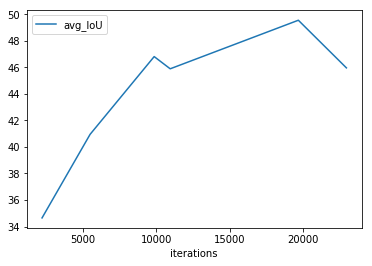

In [16]:
data.plot(x='iterations', y='avg_IoU')
plt.show()

In [17]:
CURRENT_WEIGHT = os.path.join(WEIGHTS_DIRECTORY, 'training_runs','run5_multi_gpu_lr0005_128bacth', 'yolov3-bdd100k_19692.weights')
#CURRENT_WEIGHT = os.path.join(WEIGHTS_DIRECTORY, 'training_runs','run1_newanchors', 'yolov3-bdd100k_51418.weights')

VIDEOS_DIRECTORY = '/media/dean/datastore1/datasets/BerkeleyDeepDrive/bdd100k/videos/val'
video_files = glob.glob(os.path.join(VIDEOS_DIRECTORY, '*.mov'))
VIDEO_FILE = video_files[np.random.randint(0, len(video_files))]
#VIDEO_FILE = '/media/dean/datastore/datasets/BerkeleyDeepDrive/bdd100k/videos/test/videos/f41d85d7-127effdb.mov'

TMP_FILE = os.path.splitext(VIDEO_FILE)[0]+'-rotated.mov'
FIXED_VIDEO_FILE = os.path.splitext(VIDEO_FILE)[0]+'-fixed.mov'
ANNOTATED_FILE = os.path.join('/home/dean/Desktop', os.path.splitext(VIDEO_FILE)[0]+'-annotated.mov')

if os.path.exists(FIXED_VIDEO_FILE):
    !cd $WORKING_DIRECTORY && ./darknet detector demo cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
else:
    !cd $WORKING_DIRECTORY && ffmpeg -i $VIDEO_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $TMP_FILE && ffmpeg -i  $TMP_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $FIXED_VIDEO_FILE && ./darknet detector demo cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
            

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

  48 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512 1.595 BF
  49 Shortcut Layer: 46
  50 conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256 0.177 BF
  51 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512 1.595 BF
  52 Shortcut Layer: 49
  53 conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256 0.177 BF
  54 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512 1.595 BF
  55 Shortcut Layer: 52
  56 conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256 0.177 BF
  57 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512 1.595 BF
  58 Shortcut Layer: 55
  59 conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256 0.177 BF
  60 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512 1.595 BF
  61 Shortcut Layer: 58
  62 conv   1024  3 x 3 / 2    26 x  26 x 512   ->    13 x  13 x1024 1.595 BF
  63 conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512 0.177 BF
  64 conv   1024  3 x 


FPS:40.2
Objects:

traffic light: 61% 
traffic light: 54% 
traffic light: 44% 
traffic light: 40% 
traffic light: 29% 
traffic light: 27% 
traffic light: 25% 
traffic sign: 40% 
traffic sign: 29% 
car: 98% 
car: 82% 
car: 79% 
car: 75% 
car: 74% 
car: 72% 
car: 32% 
car: 30% 
car: 26% 

FPS:38.9
Objects:

traffic light: 75% 
traffic light: 54% 
traffic light: 43% 
traffic light: 38% 
traffic light: 27% 
traffic sign: 38% 
traffic sign: 33% 
traffic sign: 29% 
car: 98% 
car: 84% 
car: 84% 
car: 80% 
car: 65% 
car: 64% 
car: 54% 
car: 41% 

FPS:35.9
Objects:

traffic light: 76% 
traffic light: 59% 
traffic light: 47% 
traffic light: 35% 
traffic light: 32% 
traffic sign: 36% 
car: 99% 
car: 95% 
car: 92% 
car: 80% 
car: 71% 
car: 52% 
car: 46% 

FPS:40.4
Objects:

traffic light: 68% 
traffic light: 57% 
traffic light: 50% 
traffic light: 43% 
traffic light: 33% 
traffic light: 30% 
traffic sign: 44% 
traffic sign: 31% 
car: 99% 
car: 93% 
car: 87% 
car: 69% 
car: 51% 
car: 50% 
car: 40%


FPS:38.2
Objects:

traffic light: 70% 
traffic light: 69% 
traffic light: 68% 
traffic light: 57% 
traffic light: 53% 
traffic light: 32% 
traffic sign: 77% 
traffic sign: 74% 
traffic sign: 48% 
car: 98% 
car: 84% 
car: 76% 
car: 65% 
car: 47% 
car: 33% 
car: 29% 

FPS:39.0
Objects:

traffic light: 68% 
traffic light: 67% 
traffic light: 64% 
traffic light: 60% 
traffic light: 48% 
traffic light: 34% 
traffic light: 31% 
traffic sign: 77% 
traffic sign: 65% 
traffic sign: 46% 
car: 97% 
car: 77% 
car: 73% 
car: 53% 
car: 45% 

FPS:36.9
Objects:

traffic light: 72% 
traffic light: 69% 
traffic light: 58% 
traffic light: 52% 
traffic light: 44% 
traffic light: 35% 
traffic light: 32% 
traffic sign: 78% 
traffic sign: 76% 
traffic sign: 41% 
car: 98% 
car: 88% 
car: 80% 
car: 72% 
car: 57% 
car: 31% 

FPS:27.9
Objects:

traffic light: 78% 
traffic light: 72% 
traffic light: 55% 
traffic light: 49% 
traffic light: 45% 
traffic light: 44% 
traffic sign: 73% 
traffic sign: 62% 
car: 98% 
c


FPS:38.0
Objects:

traffic light: 72% 
traffic light: 69% 
traffic light: 60% 
traffic light: 30% 
traffic light: 27% 
traffic light: 26% 
traffic sign: 89% 
traffic sign: 67% 
traffic sign: 35% 
car: 100% 
car: 97% 
car: 85% 
car: 40% 
car: 29% 
car: 26% 

FPS:39.2
Objects:

traffic light: 78% 
traffic light: 70% 
traffic light: 69% 
traffic light: 51% 
traffic light: 48% 
traffic light: 35% 
traffic light: 28% 
traffic sign: 87% 
traffic sign: 68% 
traffic sign: 33% 
car: 100% 
car: 98% 
car: 81% 
car: 36% 
car: 34% 

FPS:37.7
Objects:

traffic light: 87% 
traffic light: 77% 
traffic light: 77% 
traffic light: 50% 
traffic light: 43% 
traffic light: 31% 
traffic light: 29% 
traffic sign: 83% 
traffic sign: 67% 
traffic sign: 26% 
car: 100% 
car: 96% 
car: 62% 
car: 49% 
car: 39% 

FPS:35.1
Objects:

traffic light: 89% 
traffic light: 75% 
traffic light: 56% 
traffic light: 50% 
traffic light: 42% 
traffic light: 30% 
traffic light: 30% 
traffic light: 30% 
traffic light: 26% 
traffi


FPS:25.5
Objects:

traffic light: 90% 
traffic light: 83% 
traffic light: 68% 
traffic light: 61% 
traffic light: 61% 
traffic light: 39% 
traffic light: 37% 
traffic light: 35% 
traffic sign: 85% 
traffic sign: 62% 
traffic sign: 29% 
car: 100% 
car: 97% 
car: 50% 
car: 46% 

FPS:24.9
Objects:

traffic light: 90% 
traffic light: 82% 
traffic light: 67% 
traffic light: 61% 
traffic light: 60% 
traffic light: 37% 
traffic light: 33% 
traffic light: 30% 
traffic sign: 84% 
traffic sign: 59% 
car: 100% 
car: 98% 
car: 60% 
car: 40% 
car: 38% 
car: 33% 
person: 35% 

FPS:25.2
Objects:

traffic light: 91% 
traffic light: 82% 
traffic light: 67% 
traffic light: 60% 
traffic light: 58% 
traffic light: 33% 
traffic light: 31% 
traffic light: 25% 
traffic sign: 82% 
traffic sign: 58% 
traffic sign: 27% 
car: 100% 
car: 96% 
car: 69% 
car: 61% 
car: 47% 
car: 26% 

FPS:29.3
Objects:

traffic light: 90% 
traffic light: 83% 
traffic light: 66% 
traffic light: 64% 
traffic light: 60% 
traffic ligh


FPS:25.0
Objects:

traffic light: 88% 
traffic light: 71% 
traffic light: 68% 
traffic light: 65% 
traffic light: 63% 
traffic light: 45% 
traffic light: 42% 
traffic sign: 84% 
traffic sign: 61% 
traffic sign: 29% 
car: 99% 
car: 94% 
car: 93% 
car: 66% 
car: 36% 

FPS:28.4
Objects:

traffic light: 87% 
traffic light: 72% 
traffic light: 69% 
traffic light: 64% 
traffic light: 63% 
traffic light: 44% 
traffic light: 41% 
traffic sign: 84% 
traffic sign: 54% 
traffic sign: 29% 
car: 98% 
car: 94% 
car: 91% 
car: 35% 

FPS:27.9
Objects:

traffic light: 87% 
traffic light: 75% 
traffic light: 67% 
traffic light: 61% 
traffic light: 60% 
traffic light: 41% 
traffic light: 41% 
traffic sign: 83% 
traffic sign: 62% 
car: 100% 
car: 95% 
car: 92% 
car: 32% 

FPS:24.6
Objects:

traffic light: 88% 
traffic light: 76% 
traffic light: 65% 
traffic light: 61% 
traffic light: 60% 
traffic light: 44% 
traffic light: 42% 
traffic sign: 82% 
traffic sign: 63% 
car: 99% 
car: 96% 
car: 91% 
car: 32% 


FPS:25.2
Objects:

traffic light: 88% 
traffic light: 73% 
traffic light: 69% 
traffic light: 68% 
traffic light: 58% 
traffic light: 41% 
traffic light: 34% 
traffic sign: 89% 
traffic sign: 48% 
traffic sign: 37% 
car: 100% 
car: 98% 
car: 91% 
car: 31% 

FPS:28.3
Objects:

traffic light: 88% 
traffic light: 73% 
traffic light: 70% 
traffic light: 68% 
traffic light: 57% 
traffic light: 42% 
traffic light: 36% 
traffic sign: 88% 
traffic sign: 48% 
traffic sign: 35% 
car: 100% 
car: 98% 
car: 94% 
car: 31% 

FPS:26.0
Objects:

traffic light: 88% 
traffic light: 73% 
traffic light: 71% 
traffic light: 68% 
traffic light: 55% 
traffic light: 44% 
traffic light: 35% 
traffic sign: 89% 
traffic sign: 45% 
traffic sign: 41% 
car: 100% 
car: 98% 
car: 94% 
car: 34% 

FPS:26.2
Objects:

traffic light: 89% 
traffic light: 71% 
traffic light: 70% 
traffic light: 67% 
traffic light: 58% 
traffic light: 49% 
traffic light: 35% 
traffic sign: 85% 
traffic sign: 53% 
traffic sign: 41% 
car: 100%


FPS:24.1
Objects:

traffic light: 92% 
traffic light: 78% 
traffic light: 69% 
traffic light: 66% 
traffic light: 56% 
traffic light: 50% 
traffic light: 47% 
traffic sign: 92% 
traffic sign: 65% 
traffic sign: 33% 
car: 100% 
car: 98% 
car: 95% 
car: 37% 

FPS:26.0
Objects:

traffic light: 92% 
traffic light: 79% 
traffic light: 70% 
traffic light: 64% 
traffic light: 57% 
traffic light: 51% 
traffic light: 47% 
traffic sign: 91% 
traffic sign: 59% 
traffic sign: 37% 
car: 100% 
car: 98% 
car: 95% 
car: 36% 

FPS:26.2
Objects:

traffic light: 92% 
traffic light: 79% 
traffic light: 72% 
traffic light: 65% 
traffic light: 55% 
traffic light: 51% 
traffic light: 45% 
traffic sign: 91% 
traffic sign: 64% 
traffic sign: 36% 
car: 100% 
car: 98% 
car: 97% 
car: 42% 
car: 34% 

FPS:32.1
Objects:

traffic light: 92% 
traffic light: 79% 
traffic light: 73% 
traffic light: 65% 
traffic light: 55% 
traffic light: 53% 
traffic light: 44% 
traffic sign: 92% 
traffic sign: 66% 
traffic sign: 37% 


FPS:27.8
Objects:

traffic light: 92% 
traffic light: 89% 
traffic light: 73% 
traffic light: 65% 
traffic light: 59% 
traffic light: 48% 
traffic light: 44% 
traffic light: 26% 
traffic sign: 94% 
traffic sign: 62% 
traffic sign: 38% 
car: 100% 
car: 97% 
car: 93% 
car: 41% 
car: 37% 

FPS:25.9
Objects:

traffic light: 92% 
traffic light: 85% 
traffic light: 73% 
traffic light: 63% 
traffic light: 53% 
traffic light: 49% 
traffic light: 48% 
traffic sign: 94% 
traffic sign: 69% 
traffic sign: 43% 
car: 100% 
car: 97% 
car: 91% 
car: 41% 
car: 31% 

FPS:26.1
Objects:

traffic light: 93% 
traffic light: 85% 
traffic light: 72% 
traffic light: 62% 
traffic light: 61% 
traffic light: 48% 
traffic light: 40% 
traffic light: 31% 
traffic light: 30% 
traffic sign: 93% 
traffic sign: 79% 
traffic sign: 43% 
car: 100% 
car: 97% 
car: 96% 
car: 30% 

FPS:27.0
Objects:

traffic light: 92% 
traffic light: 91% 
traffic light: 71% 
traffic light: 67% 
traffic light: 59% 
traffic light: 49% 
traffi


FPS:29.4
Objects:

traffic light: 92% 
traffic light: 91% 
traffic light: 79% 
traffic light: 65% 
traffic light: 62% 
traffic light: 57% 
traffic light: 53% 
traffic light: 34% 
traffic sign: 92% 
traffic sign: 76% 
traffic sign: 31% 
car: 98% 
car: 84% 
car: 59% 
car: 58% 
car: 26% 

FPS:27.8
Objects:

traffic light: 93% 
traffic light: 89% 
traffic light: 80% 
traffic light: 62% 
traffic light: 61% 
traffic light: 60% 
traffic light: 53% 
traffic light: 33% 
traffic sign: 88% 
traffic sign: 79% 
traffic sign: 32% 
car: 98% 
car: 80% 
car: 75% 
car: 52% 
car: 48% 

FPS:26.4
Objects:

traffic light: 92% 
traffic light: 90% 
traffic light: 81% 
traffic light: 57% 
traffic light: 57% 
traffic light: 56% 
traffic light: 51% 
traffic light: 26% 
traffic sign: 87% 
traffic sign: 65% 
car: 98% 
car: 94% 
car: 83% 
car: 66% 
car: 31% 

FPS:27.1
Objects:

traffic light: 91% 
traffic light: 89% 
traffic light: 78% 
traffic light: 57% 
traffic light: 55% 
traffic light: 55% 
traffic light: 47%


FPS:28.5
Objects:

traffic light: 93% 
traffic light: 89% 
traffic light: 82% 
traffic light: 68% 
traffic light: 65% 
traffic light: 56% 
traffic light: 55% 
traffic sign: 89% 
traffic sign: 66% 
car: 100% 
car: 98% 
car: 76% 
car: 32% 
car: 31% 

FPS:25.6
Objects:

traffic light: 93% 
traffic light: 86% 
traffic light: 85% 
traffic light: 70% 
traffic light: 67% 
traffic light: 58% 
traffic light: 57% 
traffic sign: 84% 
traffic sign: 80% 
car: 100% 
car: 97% 
car: 68% 
car: 33% 
car: 29% 

FPS:25.3
Objects:

traffic light: 92% 
traffic light: 84% 
traffic light: 83% 
traffic light: 68% 
traffic light: 62% 
traffic light: 58% 
traffic light: 54% 
traffic sign: 86% 
traffic sign: 84% 
car: 100% 
car: 97% 
car: 59% 

FPS:31.5
Objects:

traffic light: 92% 
traffic light: 85% 
traffic light: 83% 
traffic light: 67% 
traffic light: 62% 
traffic light: 57% 
traffic light: 53% 
traffic sign: 87% 
traffic sign: 82% 
traffic sign: 26% 
car: 100% 
car: 98% 
car: 69% 
car: 35% 
car: 26% 

FPS:


FPS:26.8
Objects:

traffic light: 93% 
traffic light: 91% 
traffic light: 69% 
traffic light: 64% 
traffic light: 54% 
traffic light: 52% 
traffic light: 38% 
traffic light: 37% 
traffic light: 25% 
traffic sign: 89% 
traffic sign: 86% 
traffic sign: 48% 
car: 100% 
car: 98% 
car: 93% 
car: 53% 

FPS:28.5
Objects:

traffic light: 93% 
traffic light: 91% 
traffic light: 79% 
traffic light: 59% 
traffic light: 58% 
traffic light: 51% 
traffic light: 37% 
traffic light: 37% 
traffic light: 26% 
traffic sign: 90% 
traffic sign: 88% 
traffic sign: 33% 
car: 100% 
car: 97% 
car: 94% 
car: 61% 
car: 33% 

FPS:26.6
Objects:

traffic light: 93% 
traffic light: 92% 
traffic light: 84% 
traffic light: 65% 
traffic light: 54% 
traffic light: 52% 
traffic light: 40% 
traffic light: 37% 
traffic sign: 93% 
traffic sign: 81% 
traffic sign: 32% 
car: 100% 
car: 98% 
car: 93% 
car: 60% 

FPS:28.5
Objects:

traffic light: 93% 
traffic light: 92% 
traffic light: 83% 
traffic light: 64% 
traffic light: 5


FPS:26.8
Objects:

traffic light: 94% 
traffic light: 87% 
traffic light: 86% 
traffic light: 68% 
traffic light: 53% 
traffic light: 53% 
traffic light: 46% 
traffic sign: 90% 
traffic sign: 65% 
car: 100% 
car: 99% 
car: 56% 
car: 35% 

FPS:28.6
Objects:

traffic light: 93% 
traffic light: 87% 
traffic light: 83% 
traffic light: 66% 
traffic light: 54% 
traffic light: 52% 
traffic light: 41% 
traffic sign: 89% 
traffic sign: 75% 
car: 100% 
car: 100% 
car: 86% 
car: 50% 
car: 49% 

FPS:27.7
Objects:

traffic light: 94% 
traffic light: 88% 
traffic light: 82% 
traffic light: 67% 
traffic light: 59% 
traffic light: 58% 
traffic light: 48% 
traffic sign: 89% 
traffic sign: 72% 
traffic sign: 27% 
car: 99% 
car: 99% 
car: 62% 
car: 59% 
car: 47% 

FPS:32.3
Objects:

traffic light: 94% 
traffic light: 88% 
traffic light: 81% 
traffic light: 69% 
traffic light: 59% 
traffic light: 56% 
traffic light: 53% 
traffic sign: 92% 
traffic sign: 69% 
traffic sign: 35% 
car: 99% 
car: 99% 
car: 64


FPS:32.3
Objects:

traffic light: 94% 
traffic light: 92% 
traffic light: 80% 
traffic light: 64% 
traffic light: 60% 
traffic light: 60% 
traffic light: 50% 
traffic light: 48% 
traffic light: 31% 
traffic sign: 92% 
traffic sign: 70% 
car: 99% 
car: 99% 
car: 80% 
car: 72% 
car: 59% 
car: 26% 

FPS:28.7
Objects:

traffic light: 94% 
traffic light: 92% 
traffic light: 79% 
traffic light: 64% 
traffic light: 64% 
traffic light: 54% 
traffic light: 49% 
traffic light: 45% 
traffic sign: 92% 
traffic sign: 65% 
car: 100% 
car: 95% 
car: 92% 
car: 48% 
car: 47% 

FPS:25.3
Objects:

traffic light: 95% 
traffic light: 93% 
traffic light: 80% 
traffic light: 68% 
traffic light: 67% 
traffic light: 58% 
traffic light: 52% 
traffic light: 49% 
traffic sign: 92% 
traffic sign: 50% 
car: 100% 
car: 100% 
car: 95% 
car: 76% 
car: 29% 
car: 25% 

FPS:30.0
Objects:

traffic light: 95% 
traffic light: 92% 
traffic light: 81% 
traffic light: 70% 
traffic light: 64% 
traffic light: 63% 
traffic light


FPS:27.4
Objects:

traffic light: 92% 
traffic light: 92% 
traffic light: 76% 
traffic light: 73% 
traffic light: 57% 
traffic light: 54% 
traffic light: 51% 
traffic light: 42% 
traffic light: 37% 
traffic light: 32% 
traffic sign: 89% 
traffic sign: 79% 
traffic sign: 43% 
car: 100% 
car: 99% 
car: 79% 
car: 76% 
car: 56% 

FPS:30.0
Objects:

traffic light: 93% 
traffic light: 91% 
traffic light: 80% 
traffic light: 68% 
traffic light: 66% 
traffic light: 56% 
traffic light: 55% 
traffic light: 51% 
traffic light: 28% 
traffic light: 26% 
traffic sign: 90% 
traffic sign: 73% 
traffic sign: 27% 
car: 100% 
car: 99% 
car: 85% 
car: 80% 
car: 34% 

FPS:33.5
Objects:

traffic light: 94% 
traffic light: 91% 
traffic light: 80% 
traffic light: 68% 
traffic light: 63% 
traffic light: 61% 
traffic light: 59% 
traffic light: 56% 
traffic light: 25% 
traffic sign: 90% 
traffic sign: 70% 
traffic sign: 26% 
car: 100% 
car: 99% 
car: 88% 
car: 79% 
car: 34% 

FPS:26.0
Objects:

traffic light: 9


FPS:28.6
Objects:

traffic light: 90% 
traffic light: 90% 
traffic light: 73% 
traffic light: 68% 
traffic light: 63% 
traffic light: 62% 
traffic light: 55% 
traffic light: 51% 
traffic light: 33% 
traffic sign: 85% 
traffic sign: 68% 
traffic sign: 36% 
car: 100% 
car: 99% 
car: 84% 
car: 37% 

FPS:31.5
Objects:

traffic light: 92% 
traffic light: 89% 
traffic light: 76% 
traffic light: 69% 
traffic light: 67% 
traffic light: 61% 
traffic light: 58% 
traffic light: 52% 
traffic light: 29% 
traffic sign: 88% 
traffic sign: 64% 
traffic sign: 35% 
car: 100% 
car: 99% 
car: 86% 
car: 38% 

FPS:25.5
Objects:

traffic light: 91% 
traffic light: 91% 
traffic light: 76% 
traffic light: 71% 
traffic light: 67% 
traffic light: 57% 
traffic light: 55% 
traffic light: 55% 
traffic light: 27% 
traffic sign: 90% 
traffic sign: 64% 
traffic sign: 31% 
car: 100% 
car: 99% 
car: 89% 
car: 41% 

FPS:29.9
Objects:

traffic light: 91% 
traffic light: 91% 
traffic light: 77% 
traffic light: 73% 
traffi


FPS:29.6
Objects:

traffic light: 93% 
traffic light: 92% 
traffic light: 85% 
traffic light: 72% 
traffic light: 65% 
traffic light: 65% 
traffic light: 57% 
traffic light: 56% 
traffic sign: 85% 
traffic sign: 72% 
car: 100% 
car: 99% 
car: 48% 
car: 39% 
car: 30% 
car: 27% 

FPS:25.1
Objects:

traffic light: 93% 
traffic light: 92% 
traffic light: 86% 
traffic light: 75% 
traffic light: 72% 
traffic light: 60% 
traffic light: 59% 
traffic light: 53% 
traffic light: 31% 
traffic light: 29% 
traffic sign: 74% 
traffic sign: 72% 
car: 100% 
car: 98% 
car: 75% 
car: 39% 
car: 30% 
car: 28% 

FPS:24.9
Objects:

traffic light: 93% 
traffic light: 92% 
traffic light: 86% 
traffic light: 73% 
traffic light: 69% 
traffic light: 60% 
traffic light: 59% 
traffic light: 54% 
traffic light: 30% 
traffic light: 28% 
traffic sign: 77% 
traffic sign: 69% 
car: 100% 
car: 98% 
car: 71% 
car: 42% 
car: 31% 
car: 29% 

FPS:30.5
Objects:

traffic light: 93% 
traffic light: 91% 
traffic light: 85% 
tra


FPS:28.4
Objects:

traffic light: 93% 
traffic light: 91% 
traffic light: 84% 
traffic light: 63% 
traffic light: 63% 
traffic light: 61% 
traffic light: 58% 
traffic light: 56% 
traffic light: 26% 
traffic sign: 93% 
traffic sign: 63% 
car: 100% 
car: 98% 
car: 83% 
car: 28% 

FPS:28.2
Objects:

traffic light: 91% 
traffic light: 88% 
traffic light: 77% 
traffic light: 63% 
traffic light: 60% 
traffic light: 59% 
traffic light: 59% 
traffic light: 56% 
traffic sign: 91% 
traffic sign: 59% 
car: 100% 
car: 98% 
car: 76% 
car: 28% 

FPS:26.3
Objects:

traffic light: 92% 
traffic light: 86% 
traffic light: 79% 
traffic light: 61% 
traffic light: 60% 
traffic light: 56% 
traffic light: 55% 
traffic light: 52% 
traffic sign: 74% 
traffic sign: 68% 
car: 100% 
car: 98% 
car: 83% 
car: 31% 

FPS:28.4
Objects:

traffic light: 93% 
traffic light: 80% 
traffic light: 71% 
traffic light: 70% 
traffic light: 58% 
traffic light: 55% 
traffic light: 54% 
traffic light: 49% 
traffic sign: 88% 
traf

car: 93% 
car: 50% 
car: 30% 

FPS:25.2
Objects:

traffic light: 92% 
traffic light: 89% 
traffic light: 80% 
traffic light: 75% 
traffic light: 58% 
traffic light: 55% 
traffic light: 53% 
traffic light: 27% 
traffic sign: 90% 
traffic sign: 60% 
traffic sign: 37% 
traffic sign: 32% 
car: 98% 
car: 95% 
car: 95% 
car: 62% 

FPS:25.7
Objects:

traffic light: 93% 
traffic light: 89% 
traffic light: 81% 
traffic light: 75% 
traffic light: 59% 
traffic light: 55% 
traffic light: 51% 
traffic sign: 92% 
traffic sign: 63% 
traffic sign: 26% 
car: 98% 
car: 96% 
car: 94% 
car: 60% 
car: 27% 

FPS:25.8
Objects:

traffic light: 91% 
traffic light: 91% 
traffic light: 84% 
traffic light: 72% 
traffic light: 69% 
traffic light: 57% 
traffic light: 57% 
traffic light: 56% 
traffic light: 26% 
traffic sign: 90% 
traffic sign: 62% 
car: 99% 
car: 98% 
car: 91% 
car: 42% 

FPS:24.5
Objects:

traffic light: 91% 
traffic light: 90% 
traffic light: 81% 
traffic light: 68% 
traffic light: 65% 
traffic l


FPS:30.7
Objects:

traffic light: 91% 
traffic light: 90% 
traffic light: 78% 
traffic light: 70% 
traffic light: 57% 
traffic light: 53% 
traffic light: 49% 
traffic sign: 92% 
traffic sign: 49% 
car: 100% 
car: 97% 
car: 95% 
car: 36% 
car: 34% 
person: 59% 

FPS:25.6
Objects:

traffic light: 89% 
traffic light: 88% 
traffic light: 85% 
traffic light: 64% 
traffic light: 62% 
traffic light: 54% 
traffic light: 49% 
traffic sign: 90% 
traffic sign: 43% 
car: 100% 
car: 94% 
car: 94% 
car: 35% 
car: 26% 
person: 48% 

FPS:27.4
Objects:

traffic light: 88% 
traffic light: 86% 
traffic light: 85% 
traffic light: 66% 
traffic light: 62% 
traffic light: 58% 
traffic light: 52% 
traffic sign: 81% 
traffic sign: 64% 
car: 100% 
car: 95% 
car: 88% 
car: 25% 
person: 56% rider: 34% 

FPS:31.5
Objects:

traffic light: 89% 
traffic light: 89% 
traffic light: 84% 
traffic light: 66% 
traffic light: 65% 
traffic light: 55% 
traffic light: 54% 
traffic light: 52% 
traffic sign: 78% 
traffic sign: 


FPS:27.3
Objects:

traffic light: 93% 
traffic light: 90% 
traffic light: 79% 
traffic light: 65% 
traffic light: 58% 
traffic light: 58% 
traffic light: 43% 
traffic light: 26% 
traffic sign: 91% 
traffic sign: 44% 
car: 100% 
car: 94% 
car: 81% 
car: 41% 
car: 36% 

FPS:28.7
Objects:

traffic light: 92% 
traffic light: 89% 
traffic light: 79% 
traffic light: 60% 
traffic light: 59% 
traffic light: 57% 
traffic light: 35% 
traffic sign: 89% 
traffic sign: 50% 
car: 99% 
car: 96% 
car: 93% 
car: 56% 
car: 32% 

FPS:25.8
Objects:

traffic light: 91% 
traffic light: 90% 
traffic light: 80% 
traffic light: 62% 
traffic light: 61% 
traffic light: 52% 
traffic light: 40% 
traffic sign: 84% 
traffic sign: 49% 
car: 97% 
car: 93% 
car: 90% 
car: 36% 
person: 32% 

FPS:25.1
Objects:

traffic light: 87% 
traffic light: 87% 
traffic light: 82% 
traffic light: 68% 
traffic light: 59% 
traffic light: 56% 
traffic light: 42% 
traffic light: 28% 
traffic sign: 78% 
traffic sign: 69% 
traffic sign: 


FPS:33.0
Objects:

traffic light: 93% 
traffic light: 92% 
traffic light: 83% 
traffic light: 75% 
traffic light: 60% 
traffic light: 56% 
traffic light: 54% 
traffic light: 27% 
traffic sign: 92% 
traffic sign: 59% 
car: 100% 
car: 97% 
car: 72% 
car: 37% 
car: 26% 

FPS:25.3
Objects:

traffic light: 92% 
traffic light: 92% 
traffic light: 80% 
traffic light: 74% 
traffic light: 57% 
traffic light: 55% 
traffic light: 54% 
traffic sign: 93% 
traffic sign: 60% 
car: 100% 
car: 98% 
car: 43% 
car: 36% 

FPS:24.6
Objects:

traffic light: 93% 
traffic light: 93% 
traffic light: 82% 
traffic light: 75% 
traffic light: 65% 
traffic light: 59% 
traffic light: 53% 
traffic sign: 90% 
traffic sign: 54% 
car: 100% 
car: 98% 
car: 56% 
car: 29% 

FPS:27.7
Objects:

traffic light: 92% 
traffic light: 90% 
traffic light: 81% 
traffic light: 69% 
traffic light: 66% 
traffic light: 57% 
traffic light: 46% 
traffic light: 26% 
traffic sign: 88% 
traffic sign: 53% 
car: 100% 
car: 98% 
car: 61% 

FPS


FPS:24.8
Objects:

traffic light: 87% 
traffic light: 87% 
traffic light: 84% 
traffic light: 73% 
traffic light: 61% 
traffic light: 56% 
traffic sign: 87% 
traffic sign: 47% 
bike: 75% 
car: 100% 
car: 87% 
car: 61% 
car: 35% 
rider: 50% 

FPS:25.8
Objects:

traffic light: 88% 
traffic light: 87% 
traffic light: 82% 
traffic light: 71% 
traffic light: 63% 
traffic light: 53% 
traffic light: 27% 
traffic sign: 86% 
traffic sign: 49% 
bike: 36% 
car: 100% 
car: 88% 
car: 71% 
car: 36% 
car: 27% 
person: 28% rider: 66% 

FPS:25.7
Objects:

traffic light: 88% 
traffic light: 87% 
traffic light: 82% 
traffic light: 70% 
traffic light: 65% 
traffic light: 55% 
traffic light: 28% 
traffic sign: 88% 
traffic sign: 51% 
bike: 45% 
car: 100% 
car: 93% 
car: 86% 
car: 36% 
car: 33% 
rider: 43% 

FPS:25.1
Objects:

traffic light: 89% 
traffic light: 85% 
traffic light: 78% 
traffic light: 67% 
traffic light: 66% 
traffic light: 57% 
traffic light: 31% 
traffic sign: 88% 
traffic sign: 54% 
traf


FPS:24.2
Objects:

traffic light: 92% 
traffic light: 84% 
traffic light: 79% 
traffic light: 68% 
traffic light: 62% 
traffic light: 55% 
traffic light: 28% 
traffic light: 25% 
traffic sign: 92% 
traffic sign: 82% 
traffic sign: 47% 
car: 98% 
car: 97% 
car: 94% 
car: 48% 
car: 39% 
person: 38% 

FPS:26.4
Objects:

traffic light: 92% 
traffic light: 85% 
traffic light: 77% 
traffic light: 74% 
traffic light: 67% 
traffic light: 63% 
traffic light: 33% 
traffic light: 28% 
traffic light: 26% 
traffic sign: 92% 
traffic sign: 80% 
traffic sign: 47% 
car: 99% 
car: 97% 
car: 95% 
car: 44% 
car: 33% 
person: 45% 

FPS:33.2
Objects:

traffic light: 92% 
traffic light: 86% 
traffic light: 77% 
traffic light: 74% 
traffic light: 68% 
traffic light: 62% 
traffic light: 32% 
traffic light: 30% 
traffic light: 26% 
traffic light: 26% 
traffic sign: 91% 
traffic sign: 79% 
traffic sign: 45% 
car: 100% 
car: 97% 
car: 94% 
car: 40% 
car: 37% 
person: 54% 

FPS:20.1
Objects:

traffic light: 91% 


FPS:26.6
Objects:

traffic light: 85% 
traffic light: 82% 
traffic light: 78% 
traffic light: 78% 
traffic light: 71% 
traffic light: 67% 
traffic light: 44% 
traffic light: 40% 
traffic sign: 89% 
traffic sign: 79% 
traffic sign: 48% 
car: 100% 
car: 99% 
car: 63% 
car: 32% 
car: 28% 
person: 78% 

FPS:25.9
Objects:

traffic light: 84% 
traffic light: 80% 
traffic light: 74% 
traffic light: 73% 
traffic light: 70% 
traffic light: 65% 
traffic light: 45% 
traffic light: 41% 
traffic light: 30% 
traffic light: 29% 
traffic sign: 93% 
traffic sign: 79% 
traffic sign: 45% 
car: 100% 
car: 98% 
car: 75% 
car: 63% 
person: 49% 

FPS:25.6
Objects:

traffic light: 85% 
traffic light: 76% 
traffic light: 75% 
traffic light: 74% 
traffic light: 72% 
traffic light: 63% 
traffic light: 48% 
traffic light: 40% 
traffic light: 32% 
traffic light: 29% 
traffic sign: 93% 
traffic sign: 79% 
traffic sign: 43% 
car: 100% 
car: 99% 
car: 83% 
car: 63% 
person: 83% 

FPS:27.1
Objects:

traffic light: 86


FPS:27.3
Objects:

traffic light: 87% 
traffic light: 76% 
traffic light: 71% 
traffic light: 70% 
traffic light: 68% 
traffic light: 64% 
traffic light: 51% 
traffic light: 50% 
traffic light: 41% 
traffic light: 38% 
traffic sign: 91% 
traffic sign: 75% 
traffic sign: 43% 
car: 100% 
car: 98% 
car: 95% 
car: 58% 
car: 42% 

FPS:26.5
Objects:

traffic light: 87% 
traffic light: 77% 
traffic light: 73% 
traffic light: 71% 
traffic light: 69% 
traffic light: 66% 
traffic light: 54% 
traffic light: 51% 
traffic light: 41% 
traffic light: 38% 
traffic sign: 92% 
traffic sign: 76% 
traffic sign: 42% 
car: 100% 
car: 98% 
car: 95% 
car: 54% 
car: 42% 

FPS:26.1
Objects:

traffic light: 87% 
traffic light: 74% 
traffic light: 72% 
traffic light: 71% 
traffic light: 70% 
traffic light: 65% 
traffic light: 56% 
traffic light: 50% 
traffic light: 43% 
traffic light: 37% 
traffic sign: 92% 
traffic sign: 76% 
traffic sign: 37% 
car: 100% 
car: 98% 
car: 96% 
car: 46% 
car: 44% 

FPS:25.6
Object


FPS:29.6
Objects:

traffic light: 87% 
traffic light: 73% 
traffic light: 70% 
traffic light: 70% 
traffic light: 68% 
traffic light: 60% 
traffic light: 49% 
traffic light: 46% 
traffic light: 41% 
traffic light: 36% 
traffic sign: 92% 
traffic sign: 77% 
traffic sign: 29% 
car: 100% 
car: 99% 
car: 94% 
car: 46% 
car: 35% 

FPS:25.4
Objects:

traffic light: 88% 
traffic light: 73% 
traffic light: 71% 
traffic light: 71% 
traffic light: 68% 
traffic light: 60% 
traffic light: 50% 
traffic light: 41% 
traffic light: 38% 
traffic light: 35% 
traffic sign: 92% 
traffic sign: 77% 
traffic sign: 27% 
car: 100% 
car: 99% 
car: 94% 
car: 56% 
car: 37% 

FPS:26.2
Objects:

traffic light: 88% 
traffic light: 74% 
traffic light: 73% 
traffic light: 69% 
traffic light: 68% 
traffic light: 61% 
traffic light: 52% 
traffic light: 42% 
traffic light: 37% 
traffic light: 35% 
traffic sign: 92% 
traffic sign: 79% 
traffic sign: 28% 
car: 100% 
car: 99% 
car: 95% 
car: 49% 
car: 47% 

FPS:25.6
Object


FPS:28.2
Objects:

traffic light: 92% 
traffic light: 79% 
traffic light: 78% 
traffic light: 73% 
traffic light: 71% 
traffic light: 64% 
traffic light: 61% 
traffic light: 59% 
traffic light: 57% 
traffic light: 34% 
traffic sign: 93% 
traffic sign: 77% 
traffic sign: 31% 
car: 100% 
car: 98% 
car: 93% 
car: 43% 
car: 42% 

FPS:29.8
Objects:

traffic light: 92% 
traffic light: 79% 
traffic light: 79% 
traffic light: 73% 
traffic light: 71% 
traffic light: 63% 
traffic light: 61% 
traffic light: 60% 
traffic light: 58% 
traffic light: 33% 
traffic sign: 93% 
traffic sign: 76% 
traffic sign: 33% 
car: 100% 
car: 98% 
car: 94% 
car: 44% 
car: 42% 

FPS:30.1
Objects:

traffic light: 92% 
traffic light: 79% 
traffic light: 78% 
traffic light: 70% 
traffic light: 70% 
traffic light: 62% 
traffic light: 62% 
traffic light: 58% 
traffic light: 53% 
traffic light: 34% 
traffic sign: 92% 
traffic sign: 75% 
traffic sign: 33% 
car: 100% 
car: 98% 
car: 93% 
car: 59% 
car: 43% 

FPS:24.9
Object


FPS:29.5
Objects:

traffic light: 92% 
traffic light: 74% 
traffic light: 72% 
traffic light: 71% 
traffic light: 69% 
traffic light: 67% 
traffic light: 61% 
traffic light: 59% 
traffic light: 43% 
traffic light: 40% 
traffic light: 34% 
traffic sign: 92% 
traffic sign: 79% 
traffic sign: 29% 
car: 100% 
car: 98% 
car: 94% 
car: 57% 

FPS:28.5
Objects:

traffic light: 93% 
traffic light: 75% 
traffic light: 73% 
traffic light: 72% 
traffic light: 69% 
traffic light: 67% 
traffic light: 60% 
traffic light: 60% 
traffic light: 41% 
traffic light: 40% 
traffic light: 35% 
traffic sign: 91% 
traffic sign: 78% 
traffic sign: 35% 
car: 100% 
car: 99% 
car: 93% 
car: 55% 

FPS:26.3
Objects:

traffic light: 93% 
traffic light: 74% 
traffic light: 73% 
traffic light: 70% 
traffic light: 70% 
traffic light: 65% 
traffic light: 64% 
traffic light: 60% 
traffic light: 43% 
traffic light: 41% 
traffic light: 32% 
traffic sign: 91% 
traffic sign: 76% 
traffic sign: 33% 
car: 100% 
car: 98% 
car: 9


FPS:25.9
Objects:

traffic light: 92% 
traffic light: 73% 
traffic light: 72% 
traffic light: 70% 
traffic light: 62% 
traffic light: 61% 
traffic light: 59% 
traffic light: 42% 
traffic light: 40% 
traffic light: 25% 
traffic sign: 89% 
traffic sign: 72% 
car: 100% 
car: 98% 
car: 81% 
car: 75% 
car: 40% 

FPS:27.0
Objects:

traffic light: 92% 
traffic light: 74% 
traffic light: 74% 
traffic light: 69% 
traffic light: 62% 
traffic light: 61% 
traffic light: 60% 
traffic light: 41% 
traffic light: 40% 
traffic light: 27% 
traffic sign: 90% 
traffic sign: 72% 
car: 100% 
car: 99% 
car: 83% 
car: 73% 
car: 46% 

FPS:24.6
Objects:

traffic light: 92% 
traffic light: 73% 
traffic light: 72% 
traffic light: 68% 
traffic light: 66% 
traffic light: 60% 
traffic light: 59% 
traffic light: 37% 
traffic light: 36% 
traffic sign: 90% 
traffic sign: 76% 
car: 100% 
car: 99% 
car: 85% 
car: 76% 
car: 45% 

FPS:28.4
Objects:

traffic light: 92% 
traffic light: 73% 
traffic light: 71% 
traffic light


FPS:33.0
Objects:

traffic light: 91% 
traffic light: 73% 
traffic light: 73% 
traffic light: 70% 
traffic light: 61% 
traffic light: 59% 
traffic light: 49% 
traffic light: 39% 
traffic light: 38% 
traffic sign: 91% 
traffic sign: 79% 
car: 100% 
car: 98% 
car: 64% 
car: 61% 
car: 45% 

FPS:23.8
Objects:

traffic light: 91% 
traffic light: 72% 
traffic light: 71% 
traffic light: 70% 
traffic light: 62% 
traffic light: 59% 
traffic light: 53% 
traffic light: 40% 
traffic light: 38% 
traffic sign: 90% 
traffic sign: 79% 
car: 100% 
car: 99% 
car: 67% 
car: 50% 
car: 41% 
person: 29% 

FPS:26.6
Objects:

traffic light: 91% 
traffic light: 72% 
traffic light: 71% 
traffic light: 70% 
traffic light: 64% 
traffic light: 61% 
traffic light: 48% 
traffic light: 42% 
traffic light: 40% 
traffic sign: 91% 
traffic sign: 79% 
car: 100% 
car: 99% 
car: 72% 
car: 47% 
car: 46% 

FPS:26.0
Objects:

traffic light: 91% 
traffic light: 72% 
traffic light: 71% 
traffic light: 71% 
traffic light: 64% 



FPS:26.1
Objects:

traffic light: 92% 
traffic light: 73% 
traffic light: 72% 
traffic light: 72% 
traffic light: 67% 
traffic light: 61% 
traffic light: 47% 
traffic light: 42% 
traffic light: 40% 
traffic sign: 86% 
traffic sign: 79% 
car: 100% 
car: 98% 
car: 38% 
car: 32% 
person: 33% 
person: 31% 

FPS:30.9
Objects:

traffic light: 92% 
traffic light: 73% 
traffic light: 72% 
traffic light: 70% 
traffic light: 67% 
traffic light: 58% 
traffic light: 47% 
traffic light: 40% 
traffic light: 39% 
traffic sign: 85% 
traffic sign: 78% 
car: 100% 
car: 98% 
car: 39% 
car: 33% 
person: 48% 
person: 45% 

FPS:30.8
Objects:

traffic light: 92% 
traffic light: 74% 
traffic light: 72% 
traffic light: 68% 
traffic light: 66% 
traffic light: 57% 
traffic light: 45% 
traffic light: 40% 
traffic light: 37% 
traffic sign: 87% 
traffic sign: 79% 
car: 100% 
car: 98% 
car: 36% 
car: 29% 
person: 45% 
person: 38% 

FPS:29.2
Objects:

traffic light: 92% 
traffic light: 74% 
traffic light: 73% 
traff


FPS:28.5
Objects:

traffic light: 92% 
traffic light: 74% 
traffic light: 72% 
traffic light: 72% 
traffic light: 67% 
traffic light: 52% 
traffic light: 41% 
traffic light: 36% 
traffic sign: 91% 
traffic sign: 74% 
car: 100% 
car: 98% 
car: 43% 
car: 30% 
car: 29% 

FPS:25.0
Objects:

traffic light: 92% 
traffic light: 75% 
traffic light: 71% 
traffic light: 70% 
traffic light: 66% 
traffic light: 51% 
traffic light: 39% 
traffic light: 35% 
traffic sign: 91% 
traffic sign: 77% 
car: 100% 
car: 98% 
car: 45% 
car: 33% 
car: 32% 

FPS:25.2
Objects:

traffic light: 92% 
traffic light: 75% 
traffic light: 72% 
traffic light: 70% 
traffic light: 64% 
traffic light: 51% 
traffic light: 40% 
traffic light: 36% 
traffic sign: 91% 
traffic sign: 72% 
car: 100% 
car: 98% 
car: 48% 
car: 33% 
car: 30% 

FPS:27.7
Objects:

traffic light: 92% 
traffic light: 75% 
traffic light: 72% 
traffic light: 71% 
traffic light: 65% 
traffic light: 51% 
traffic light: 39% 
traffic light: 38% 
traffic sign:


FPS:26.5
Objects:

traffic light: 92% 
traffic light: 70% 
traffic light: 69% 
traffic light: 68% 
traffic light: 62% 
traffic light: 55% 
traffic light: 43% 
traffic light: 38% 
traffic sign: 91% 
traffic sign: 80% 
car: 100% 
car: 98% 
car: 37% 
car: 33% 

FPS:26.7
Objects:

traffic light: 92% 
traffic light: 71% 
traffic light: 67% 
traffic light: 66% 
traffic light: 65% 
traffic light: 58% 
traffic light: 46% 
traffic light: 37% 
traffic sign: 91% 
traffic sign: 81% 
car: 100% 
car: 98% 
car: 42% 

FPS:27.8
Objects:

traffic light: 92% 
traffic light: 72% 
traffic light: 68% 
traffic light: 66% 
traffic light: 66% 
traffic light: 60% 
traffic light: 45% 
traffic light: 38% 
traffic sign: 92% 
traffic sign: 79% 
car: 100% 
car: 97% 
car: 41% 
car: 27% 
car: 26% 

FPS:24.7
Objects:

traffic light: 92% 
traffic light: 72% 
traffic light: 69% 
traffic light: 68% 
traffic light: 66% 
traffic light: 59% 
traffic light: 46% 
traffic light: 38% 
traffic sign: 92% 
traffic sign: 77% 
car: 


FPS:24.7
Objects:

traffic light: 91% 
traffic light: 72% 
traffic light: 71% 
traffic light: 69% 
traffic light: 67% 
traffic light: 64% 
traffic light: 47% 
traffic light: 31% 
traffic sign: 91% 
traffic sign: 75% 
car: 100% 
car: 98% 
car: 39% 
car: 32% 

FPS:26.5
Objects:

traffic light: 92% 
traffic light: 72% 
traffic light: 71% 
traffic light: 69% 
traffic light: 63% 
traffic light: 63% 
traffic light: 46% 
traffic light: 32% 
traffic sign: 90% 
traffic sign: 74% 
car: 100% 
car: 98% 
car: 37% 
car: 31% 

FPS:29.4
Objects:

traffic light: 92% 
traffic light: 71% 
traffic light: 69% 
traffic light: 69% 
traffic light: 65% 
traffic light: 61% 
traffic light: 47% 
traffic light: 31% 
traffic sign: 90% 
traffic sign: 76% 
car: 100% 
car: 98% 
car: 39% 
car: 36% 

FPS:25.1
Objects:

traffic light: 92% 
traffic light: 69% 
traffic light: 69% 
traffic light: 68% 
traffic light: 64% 
traffic light: 62% 
traffic light: 45% 
traffic light: 32% 
traffic sign: 90% 
traffic sign: 74% 
car: 


FPS:24.1
Objects:

traffic light: 93% 
traffic light: 75% 
traffic light: 72% 
traffic light: 69% 
traffic light: 64% 
traffic light: 64% 
traffic light: 43% 
traffic light: 38% 
traffic sign: 91% 
traffic sign: 76% 
car: 100% 
car: 98% 
car: 36% 
car: 34% 

FPS:28.4
Objects:

traffic light: 93% 
traffic light: 75% 
traffic light: 72% 
traffic light: 71% 
traffic light: 66% 
traffic light: 65% 
traffic light: 38% 
traffic light: 38% 
traffic sign: 91% 
traffic sign: 81% 
car: 100% 
car: 98% 
car: 36% 
car: 36% 

FPS:32.6
Objects:

traffic light: 93% 
traffic light: 73% 
traffic light: 73% 
traffic light: 70% 
traffic light: 68% 
traffic light: 63% 
traffic light: 44% 
traffic light: 38% 
traffic sign: 91% 
traffic sign: 79% 
car: 100% 
car: 98% 
car: 37% 
car: 34% 

FPS:24.0
Objects:

traffic light: 92% 
traffic light: 74% 
traffic light: 69% 
traffic light: 65% 
traffic light: 59% 
traffic light: 56% 
traffic light: 37% 
traffic light: 35% 
traffic sign: 88% 
traffic sign: 78% 
car: 


FPS:28.3
Objects:

traffic light: 74% 
traffic light: 66% 
traffic light: 63% 
traffic light: 41% 
traffic sign: 91% 
traffic sign: 70% 
car: 100% 
car: 98% 
car: 40% 
car: 35% 

FPS:26.2
Objects:

traffic light: 74% 
traffic light: 66% 
traffic light: 61% 
traffic light: 42% 
traffic sign: 91% 
traffic sign: 70% 
traffic sign: 26% 
car: 100% 
car: 99% 
car: 35% 
car: 34% 

FPS:24.4
Objects:

traffic light: 76% 
traffic light: 66% 
traffic light: 59% 
traffic light: 41% 
traffic sign: 90% 
traffic sign: 66% 
traffic sign: 26% 
car: 100% 
car: 99% 
car: 38% 
car: 36% 

FPS:27.4
Objects:

traffic light: 77% 
traffic light: 66% 
traffic light: 60% 
traffic light: 41% 
traffic sign: 91% 
traffic sign: 66% 
traffic sign: 29% 
car: 100% 
car: 99% 
car: 37% 
car: 33% 

FPS:27.5
Objects:

traffic light: 75% 
traffic light: 67% 
traffic light: 62% 
traffic light: 41% 
traffic sign: 92% 
traffic sign: 65% 
traffic sign: 28% 
car: 100% 
car: 98% 
car: 35% 
car: 28% 

FPS:26.9
Objects:

traffic l


FPS:25.0
Objects:

traffic light: 85% 
traffic light: 66% 
traffic light: 53% 
traffic light: 41% 
traffic light: 40% 
traffic light: 30% 
traffic sign: 87% 
traffic sign: 45% 
traffic sign: 31% 
car: 100% 
car: 96% 
car: 38% 
car: 34% 

FPS:26.3
Objects:

traffic light: 86% 
traffic light: 66% 
traffic light: 53% 
traffic light: 42% 
traffic light: 39% 
traffic light: 30% 
traffic sign: 88% 
traffic sign: 48% 
traffic sign: 33% 
car: 100% 
car: 97% 
car: 42% 
car: 29% 
car: 26% 

FPS:29.8
Objects:

traffic light: 87% 
traffic light: 66% 
traffic light: 54% 
traffic light: 40% 
traffic light: 39% 
traffic light: 31% 
traffic sign: 81% 
traffic sign: 39% 
traffic sign: 26% 
car: 100% 
car: 96% 
car: 36% 
car: 35% 
car: 28% 

FPS:24.6
Objects:

traffic light: 88% 
traffic light: 65% 
traffic light: 56% 
traffic light: 49% 
traffic light: 40% 
traffic light: 31% 
traffic sign: 86% 
traffic sign: 39% 
traffic sign: 26% 
car: 99% 
car: 96% 
car: 47% 
car: 43% 
car: 30% 

FPS:27.7
Objects:



FPS:27.0
Objects:

traffic light: 67% 
traffic light: 58% 
traffic light: 49% 
traffic light: 28% 
traffic sign: 52% 
car: 100% 
car: 97% 
car: 87% 
car: 49% 

FPS:25.2
Objects:

traffic light: 63% 
traffic light: 56% 
traffic light: 48% 
traffic light: 27% 
traffic sign: 57% 
car: 100% 
car: 97% 
car: 86% 
car: 44% 
car: 32% 

FPS:25.3
Objects:

traffic light: 62% 
traffic light: 48% 
traffic light: 39% 
traffic sign: 53% 
car: 100% 
car: 97% 
car: 81% 
car: 48% 
car: 43% 

FPS:25.8
Objects:

traffic light: 76% 
traffic light: 44% 
traffic sign: 49% 
car: 100% 
car: 97% 
car: 84% 
car: 47% 
car: 46% 

FPS:33.5
Objects:

traffic light: 77% 
traffic light: 41% 
traffic light: 28% 
traffic sign: 55% 
car: 100% 
car: 97% 
car: 78% 
car: 39% 
car: 36% 

FPS:21.4
Objects:

traffic light: 81% 
traffic light: 37% 
traffic light: 31% 
traffic sign: 52% 
car: 100% 
car: 93% 
car: 76% 
car: 42% 
car: 41% 

FPS:29.6
Objects:

traffic light: 80% 
traffic light: 39% 
traffic light: 35% 
traffic li


FPS:23.8
Objects:

traffic light: 32% 
traffic sign: 72% 
car: 99% 
car: 71% 
car: 58% 
car: 47% 
car: 37% 

FPS:25.7
Objects:

traffic sign: 59% 
car: 100% 
car: 72% 
car: 62% 
car: 52% 
car: 49% 

FPS:32.4
Objects:

traffic sign: 65% 
traffic sign: 60% 
car: 100% 
car: 86% 
car: 48% 
car: 45% 
car: 44% 

FPS:23.5
Objects:

traffic sign: 45% 
traffic sign: 37% 
car: 100% 
car: 82% 
car: 59% 
car: 37% 
car: 35% 

FPS:24.3
Objects:

traffic sign: 59% 
car: 100% 
car: 73% 
car: 59% 
car: 38% 
car: 29% 

FPS:26.4
Objects:

traffic sign: 51% 
traffic sign: 32% 
car: 100% 
car: 70% 
car: 54% 
car: 41% 

FPS:28.0
Objects:

traffic sign: 60% 
car: 100% 
car: 55% 
car: 52% 
car: 33% 

FPS:29.2
Objects:

traffic sign: 56% 
car: 99% 
car: 76% 
car: 61% 
car: 48% 

FPS:24.8
Objects:

traffic light: 26% 
traffic sign: 30% 
car: 100% 
car: 72% 
car: 67% 
car: 45% 

FPS:26.8
Objects:

traffic sign: 65% 
car: 100% 
car: 76% 
car: 73% 
car: 63% 

FPS:27.9
Objects:

traffic light: 43% 
traffic sign: 5

In [20]:
CURRENT_WEIGHT = os.path.join(WEIGHTS_DIRECTORY, 'training_runs','run5_multi_gpu_lr0005_128bacth', 'yolov3-bdd100k_22974.weights')
WORKING_DIRECTORY = '/media/dean/datastore1/datasets/darknet_evaluate/'
if os.path.exists(FIXED_VIDEO_FILE):
    !cd $WORKING_DIRECTORY && ./darknet detector demo cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
else:
    !cd $WORKING_DIRECTORY && ffmpeg -i $VIDEO_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $TMP_FILE && ffmpeg -i  $TMP_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $FIXED_VIDEO_FILE && ./darknet detector demo cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
            

Demo
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
 


FPS:39.1
Objects:

traffic light: 71% 
traffic light: 68% 
traffic light: 47% 
traffic light: 46% 
traffic light: 45% 
traffic sign: 26% 
traffic sign: 25% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 79% 
car: 73% 
car: 52% 

FPS:38.8
Objects:

traffic light: 74% 
traffic light: 71% 
traffic light: 54% 
traffic light: 48% 
traffic light: 43% 
traffic sign: 30% 
car: 99% 
car: 98% 
car: 98% 
car: 97% 
car: 88% 
car: 84% 
car: 50% 
car: 29% 

FPS:37.1
Objects:

traffic light: 71% 
traffic light: 67% 
traffic light: 59% 
traffic light: 45% 
traffic light: 45% 
car: 99% 
car: 98% 
car: 98% 
car: 97% 
car: 91% 
car: 80% 
car: 48% 
car: 25% 

FPS:36.0
Objects:

traffic light: 79% 
traffic light: 56% 
traffic light: 54% 
traffic light: 42% 
traffic light: 40% 
traffic light: 26% 
traffic sign: 31% 
car: 99% 
car: 98% 
car: 98% 
car: 97% 
car: 97% 
car: 79% 
car: 31% 

FPS:34.4
Objects:

traffic light: 78% 
traffic light: 66% 
traffic light: 63% 
traffic light: 42% 
traffic light: 32% 
traf


FPS:30.8
Objects:

traffic light: 91% 
traffic light: 79% 
traffic light: 77% 
traffic light: 62% 
traffic light: 53% 
traffic light: 52% 
traffic sign: 44% 
traffic sign: 34% 
traffic sign: 28% 
car: 99% 
car: 98% 
car: 94% 
car: 91% 
car: 71% 

FPS:37.7
Objects:

traffic light: 91% 
traffic light: 71% 
traffic light: 70% 
traffic light: 63% 
traffic light: 54% 
traffic light: 45% 
traffic sign: 48% 
traffic sign: 47% 
traffic sign: 40% 
car: 95% 
car: 93% 
car: 90% 
car: 88% 
car: 36% 

FPS:36.3
Objects:

traffic light: 89% 
traffic light: 73% 
traffic light: 67% 
traffic light: 62% 
traffic light: 42% 
traffic light: 38% 
traffic sign: 58% 
traffic sign: 56% 
traffic sign: 33% 
car: 99% 
car: 97% 
car: 92% 
car: 88% 
car: 25% 

FPS:38.7
Objects:

traffic light: 86% 
traffic light: 70% 
traffic light: 62% 
traffic light: 52% 
traffic light: 45% 
traffic light: 32% 
traffic sign: 60% 
traffic sign: 45% 
car: 98% 
car: 95% 
car: 88% 
car: 85% 
person: 36% 

FPS:40.5
Objects:

traffic 


FPS:36.4
Objects:

traffic light: 87% 
traffic light: 81% 
traffic light: 71% 
traffic light: 63% 
traffic light: 57% 
traffic light: 37% 
traffic sign: 87% 
traffic sign: 63% 
traffic sign: 55% 
car: 98% 
car: 98% 
car: 71% 
car: 64% 
car: 56% 

FPS:38.2
Objects:

traffic light: 84% 
traffic light: 80% 
traffic light: 71% 
traffic light: 70% 
traffic light: 69% 
traffic light: 42% 
traffic sign: 93% 
traffic sign: 62% 
traffic sign: 61% 
car: 99% 
car: 97% 
car: 72% 
car: 67% 
car: 58% 

FPS:34.1
Objects:

traffic light: 87% 
traffic light: 83% 
traffic light: 77% 
traffic light: 64% 
traffic light: 64% 
traffic light: 48% 
traffic sign: 87% 
traffic sign: 64% 
traffic sign: 62% 
car: 99% 
car: 98% 
car: 70% 
car: 57% 
car: 45% 

FPS:32.8
Objects:

traffic light: 89% 
traffic light: 80% 
traffic light: 78% 
traffic light: 66% 
traffic light: 57% 
traffic light: 52% 
traffic sign: 74% 
traffic sign: 63% 
traffic sign: 56% 
car: 99% 
car: 97% 
car: 69% 
car: 50% 
car: 48% 
car: 31% 

F


FPS:37.0
Objects:

traffic light: 87% 
traffic light: 71% 
traffic light: 65% 
traffic light: 63% 
traffic light: 59% 
traffic light: 48% 
traffic light: 39% 
traffic light: 28% 
traffic sign: 82% 
traffic sign: 69% 
bike: 33% 
car: 100% 
car: 97% 
car: 92% 
car: 79% 
car: 48% 
rider: 38% 

FPS:38.0
Objects:

traffic light: 79% 
traffic light: 75% 
traffic light: 63% 
traffic light: 58% 
traffic light: 54% 
traffic light: 47% 
traffic light: 43% 
traffic sign: 83% 
traffic sign: 65% 
car: 100% 
car: 98% 
car: 89% 
car: 71% 
car: 48% 
rider: 26% 

FPS:36.9
Objects:

traffic light: 79% 
traffic light: 77% 
traffic light: 67% 
traffic light: 58% 
traffic light: 57% 
traffic light: 50% 
traffic light: 46% 
traffic light: 35% 
traffic sign: 81% 
traffic sign: 74% 
traffic sign: 26% 
car: 100% 
car: 96% 
car: 92% 
car: 75% 
car: 42% 

FPS:38.2
Objects:

traffic light: 82% 
traffic light: 78% 
traffic light: 66% 
traffic light: 61% 
traffic light: 57% 
traffic light: 54% 
traffic light: 44% 


FPS:29.6
Objects:

traffic light: 92% 
traffic light: 71% 
traffic light: 71% 
traffic light: 67% 
traffic light: 60% 
traffic light: 41% 
traffic light: 40% 
traffic light: 33% 
traffic sign: 86% 
traffic sign: 45% 
car: 100% 
car: 99% 
car: 94% 
car: 44% 

FPS:29.8
Objects:

traffic light: 89% 
traffic light: 74% 
traffic light: 70% 
traffic light: 63% 
traffic light: 53% 
traffic light: 44% 
traffic light: 37% 
traffic light: 30% 
traffic sign: 88% 
traffic sign: 53% 
traffic sign: 26% 
car: 100% 
car: 99% 
car: 96% 
car: 60% 
car: 32% 
car: 26% 

FPS:27.5
Objects:

traffic light: 90% 
traffic light: 74% 
traffic light: 71% 
traffic light: 65% 
traffic light: 49% 
traffic light: 45% 
traffic light: 35% 
traffic light: 28% 
traffic sign: 91% 
traffic sign: 50% 
car: 100% 
car: 97% 
car: 96% 
car: 48% 
car: 37% 
car: 36% 

FPS:26.1
Objects:

traffic light: 90% 
traffic light: 74% 
traffic light: 69% 
traffic light: 63% 
traffic light: 49% 
traffic light: 46% 
traffic light: 34% 
traf


FPS:33.4
Objects:

traffic light: 91% 
traffic light: 73% 
traffic light: 69% 
traffic light: 62% 
traffic light: 57% 
traffic light: 36% 
traffic light: 34% 
traffic light: 27% 
traffic sign: 87% 
traffic sign: 36% 
car: 100% 
car: 99% 
car: 90% 
car: 58% 
car: 44% 
car: 38% 

FPS:29.4
Objects:

traffic light: 91% 
traffic light: 70% 
traffic light: 70% 
traffic light: 62% 
traffic light: 57% 
traffic light: 41% 
traffic light: 36% 
traffic light: 27% 
traffic sign: 90% 
traffic sign: 44% 
car: 100% 
car: 100% 
car: 96% 
car: 47% 
car: 42% 
car: 35% 
car: 27% 

FPS:30.5
Objects:

traffic light: 91% 
traffic light: 72% 
traffic light: 70% 
traffic light: 63% 
traffic light: 59% 
traffic light: 40% 
traffic light: 38% 
traffic light: 25% 
traffic sign: 90% 
traffic sign: 29% 
car: 100% 
car: 100% 
car: 99% 
car: 50% 
car: 46% 
car: 29% 

FPS:27.4
Objects:

traffic light: 92% 
traffic light: 73% 
traffic light: 70% 
traffic light: 62% 
traffic light: 59% 
traffic light: 40% 
traffic lig


FPS:34.2
Objects:

traffic light: 95% 
traffic light: 77% 
traffic light: 70% 
traffic light: 54% 
traffic light: 54% 
traffic light: 41% 
traffic light: 40% 
traffic sign: 88% 
traffic sign: 47% 
traffic sign: 27% 
car: 100% 
car: 100% 
car: 89% 
car: 69% 
car: 65% 

FPS:23.0
Objects:

traffic light: 95% 
traffic light: 74% 
traffic light: 71% 
traffic light: 54% 
traffic light: 50% 
traffic light: 40% 
traffic light: 38% 
traffic sign: 85% 
traffic sign: 45% 
car: 100% 
car: 100% 
car: 94% 
car: 65% 
car: 60% 

FPS:26.7
Objects:

traffic light: 95% 
traffic light: 73% 
traffic light: 69% 
traffic light: 56% 
traffic light: 50% 
traffic light: 40% 
traffic light: 39% 
traffic sign: 86% 
traffic sign: 52% 
car: 100% 
car: 100% 
car: 95% 
car: 65% 
car: 45% 

FPS:26.9
Objects:

traffic light: 95% 
traffic light: 73% 
traffic light: 71% 
traffic light: 58% 
traffic light: 50% 
traffic light: 41% 
traffic light: 40% 
traffic sign: 86% 
traffic sign: 47% 
traffic sign: 26% 
car: 100% 
car


FPS:26.0
Objects:

traffic light: 95% 
traffic light: 73% 
traffic light: 68% 
traffic light: 59% 
traffic light: 52% 
traffic light: 44% 
traffic light: 44% 
traffic sign: 90% 
traffic sign: 45% 
traffic sign: 32% 
car: 100% 
car: 98% 
car: 97% 
car: 57% 

FPS:31.7
Objects:

traffic light: 95% 
traffic light: 75% 
traffic light: 68% 
traffic light: 60% 
traffic light: 55% 
traffic light: 44% 
traffic light: 41% 
traffic sign: 88% 
traffic sign: 51% 
traffic sign: 32% 
car: 100% 
car: 98% 
car: 97% 
car: 68% 

FPS:31.5
Objects:

traffic light: 95% 
traffic light: 74% 
traffic light: 69% 
traffic light: 64% 
traffic light: 55% 
traffic light: 42% 
traffic light: 40% 
traffic sign: 87% 
traffic sign: 53% 
traffic sign: 33% 
car: 100% 
car: 98% 
car: 95% 
car: 66% 
car: 28% 

FPS:27.6
Objects:

traffic light: 95% 
traffic light: 76% 
traffic light: 68% 
traffic light: 59% 
traffic light: 54% 
traffic light: 47% 
traffic light: 40% 
traffic sign: 87% 
traffic sign: 50% 
traffic sign: 34% 


FPS:32.5
Objects:

traffic light: 95% 
traffic light: 94% 
traffic light: 77% 
traffic light: 64% 
traffic light: 59% 
traffic light: 57% 
traffic light: 51% 
traffic light: 40% 
traffic sign: 92% 
traffic sign: 60% 
car: 99% 
car: 96% 
car: 88% 
car: 72% 
car: 43% 

FPS:27.3
Objects:

traffic light: 96% 
traffic light: 94% 
traffic light: 81% 
traffic light: 61% 
traffic light: 59% 
traffic light: 58% 
traffic light: 52% 
traffic light: 31% 
traffic sign: 92% 
traffic sign: 57% 
traffic sign: 31% 
car: 99% 
car: 95% 
car: 92% 
car: 69% 
car: 36% 

FPS:33.8
Objects:

traffic light: 96% 
traffic light: 94% 
traffic light: 84% 
traffic light: 61% 
traffic light: 59% 
traffic light: 56% 
traffic light: 51% 
traffic sign: 92% 
traffic sign: 57% 
traffic sign: 30% 
car: 99% 
car: 98% 
car: 93% 
car: 63% 
car: 37% 

FPS:25.9
Objects:

traffic light: 96% 
traffic light: 94% 
traffic light: 84% 
traffic light: 63% 
traffic light: 57% 
traffic light: 53% 
traffic light: 47% 
traffic sign: 91% 


FPS:33.9
Objects:

traffic light: 95% 
traffic light: 91% 
traffic light: 83% 
traffic light: 72% 
traffic light: 57% 
traffic light: 55% 
traffic light: 53% 
traffic light: 38% 
traffic sign: 92% 
traffic sign: 48% 
car: 100% 
car: 99% 
car: 94% 
car: 80% 
car: 31% 

FPS:28.1
Objects:

traffic light: 95% 
traffic light: 90% 
traffic light: 83% 
traffic light: 72% 
traffic light: 59% 
traffic light: 57% 
traffic light: 55% 
traffic light: 32% 
traffic sign: 91% 
traffic sign: 56% 
car: 100% 
car: 98% 
car: 81% 
car: 79% 

FPS:29.5
Objects:

traffic light: 96% 
traffic light: 90% 
traffic light: 87% 
traffic light: 71% 
traffic light: 59% 
traffic light: 57% 
traffic light: 50% 
traffic sign: 88% 
traffic sign: 63% 
car: 100% 
car: 98% 
car: 86% 
car: 81% 
car: 27% 

FPS:25.0
Objects:

traffic light: 95% 
traffic light: 92% 
traffic light: 90% 
traffic light: 71% 
traffic light: 63% 
traffic light: 59% 
traffic light: 41% 
traffic sign: 79% 
traffic sign: 66% 
car: 100% 
car: 99% 
car:


FPS:28.5
Objects:

traffic light: 96% 
traffic light: 85% 
traffic light: 77% 
traffic light: 69% 
traffic light: 66% 
traffic light: 58% 
traffic light: 40% 
traffic sign: 81% 
traffic sign: 72% 
traffic sign: 26% 
car: 100% 
car: 99% 
car: 81% 
car: 49% 
car: 36% 

FPS:28.4
Objects:

traffic light: 95% 
traffic light: 91% 
traffic light: 81% 
traffic light: 71% 
traffic light: 64% 
traffic light: 62% 
traffic light: 48% 
traffic sign: 83% 
traffic sign: 67% 
car: 100% 
car: 99% 
car: 88% 
car: 63% 
car: 29% 
car: 26% 

FPS:23.7
Objects:

traffic light: 96% 
traffic light: 95% 
traffic light: 87% 
traffic light: 70% 
traffic light: 66% 
traffic light: 62% 
traffic light: 54% 
traffic sign: 92% 
traffic sign: 79% 
traffic sign: 26% 
car: 100% 
car: 98% 
car: 89% 
car: 81% 
car: 51% 

FPS:25.9
Objects:

traffic light: 96% 
traffic light: 94% 
traffic light: 76% 
traffic light: 70% 
traffic light: 58% 
traffic light: 56% 
traffic light: 55% 
traffic light: 26% 
traffic sign: 94% 
traffi


FPS:25.7
Objects:

traffic light: 96% 
traffic light: 92% 
traffic light: 86% 
traffic light: 67% 
traffic light: 64% 
traffic light: 62% 
traffic light: 55% 
traffic sign: 92% 
traffic sign: 75% 
car: 100% 
car: 100% 
car: 90% 
car: 87% 
car: 33% 

FPS:29.8
Objects:

traffic light: 96% 
traffic light: 91% 
traffic light: 90% 
traffic light: 65% 
traffic light: 63% 
traffic light: 61% 
traffic light: 48% 
traffic sign: 92% 
traffic sign: 77% 
car: 100% 
car: 100% 
car: 85% 
car: 78% 
car: 49% 
car: 38% 

FPS:24.8
Objects:

traffic light: 96% 
traffic light: 90% 
traffic light: 90% 
traffic light: 67% 
traffic light: 64% 
traffic light: 53% 
traffic light: 42% 
traffic sign: 92% 
traffic sign: 76% 
car: 100% 
car: 100% 
car: 94% 
car: 64% 
car: 62% 
car: 29% 

FPS:26.8
Objects:

traffic light: 96% 
traffic light: 88% 
traffic light: 86% 
traffic light: 71% 
traffic light: 57% 
traffic light: 54% 
traffic light: 39% 
traffic sign: 88% 
traffic sign: 74% 
car: 100% 
car: 100% 
car: 91% 


car: 98% 
car: 97% 
car: 91% 
car: 48% 
car: 38% 

FPS:26.6
Objects:

traffic light: 96% 
traffic light: 92% 
traffic light: 87% 
traffic light: 66% 
traffic light: 66% 
traffic light: 60% 
traffic light: 53% 
traffic light: 49% 
traffic sign: 86% 
traffic sign: 64% 
car: 100% 
car: 99% 
car: 89% 
car: 89% 
car: 48% 
car: 44% 

FPS:26.2
Objects:

traffic light: 96% 
traffic light: 93% 
traffic light: 88% 
traffic light: 64% 
traffic light: 57% 
traffic light: 56% 
traffic light: 55% 
traffic light: 52% 
traffic sign: 91% 
traffic sign: 62% 
car: 100% 
car: 92% 
car: 89% 
car: 78% 
car: 37% 
car: 28% 

FPS:28.3
Objects:

traffic light: 96% 
traffic light: 93% 
traffic light: 81% 
traffic light: 62% 
traffic light: 58% 
traffic light: 58% 
traffic light: 54% 
traffic light: 53% 
traffic sign: 91% 
traffic sign: 55% 
car: 100% 
car: 98% 
car: 80% 
car: 79% 
car: 52% 
car: 48% 

FPS:25.6
Objects:

traffic light: 97% 
traffic light: 92% 
traffic light: 83% 
traffic light: 67% 
traffic light


FPS:29.8
Objects:

traffic light: 94% 
traffic light: 94% 
traffic light: 79% 
traffic light: 66% 
traffic light: 59% 
traffic light: 57% 
traffic light: 56% 
traffic light: 43% 
traffic light: 35% 
traffic light: 35% 
traffic sign: 84% 
traffic sign: 71% 
traffic sign: 27% 
car: 100% 
car: 99% 
car: 84% 
car: 79% 
car: 64% 

FPS:28.3
Objects:

traffic light: 95% 
traffic light: 94% 
traffic light: 83% 
traffic light: 74% 
traffic light: 62% 
traffic light: 58% 
traffic light: 56% 
traffic light: 45% 
traffic light: 44% 
traffic light: 30% 
traffic sign: 90% 
traffic sign: 61% 
car: 100% 
car: 99% 
car: 74% 
car: 74% 
car: 67% 

FPS:23.4
Objects:

traffic light: 94% 
traffic light: 94% 
traffic light: 81% 
traffic light: 75% 
traffic light: 60% 
traffic light: 56% 
traffic light: 51% 
traffic light: 44% 
traffic light: 42% 
traffic light: 29% 
traffic sign: 91% 
traffic sign: 64% 
traffic sign: 30% 
car: 100% 
car: 99% 
car: 75% 
car: 70% 
car: 68% 

FPS:28.6
Objects:

traffic light: 


FPS:29.2
Objects:

traffic light: 95% 
traffic light: 90% 
traffic light: 80% 
traffic light: 71% 
traffic light: 66% 
traffic light: 56% 
traffic light: 54% 
traffic light: 45% 
traffic light: 33% 
traffic light: 29% 
traffic sign: 90% 
traffic sign: 61% 
traffic sign: 27% 
car: 100% 
car: 99% 
car: 81% 
car: 77% 

FPS:29.3
Objects:

traffic light: 94% 
traffic light: 92% 
traffic light: 73% 
traffic light: 71% 
traffic light: 62% 
traffic light: 59% 
traffic light: 54% 
traffic light: 48% 
traffic light: 25% 
traffic sign: 89% 
traffic sign: 63% 
traffic sign: 31% 
car: 100% 
car: 100% 
car: 85% 
car: 80% 
car: 32% 

FPS:25.2
Objects:

traffic light: 95% 
traffic light: 93% 
traffic light: 72% 
traffic light: 68% 
traffic light: 63% 
traffic light: 61% 
traffic light: 52% 
traffic light: 51% 
traffic light: 26% 
traffic sign: 89% 
traffic sign: 69% 
traffic sign: 34% 
car: 100% 
car: 99% 
car: 82% 
car: 78% 
car: 26% 

FPS:25.0
Objects:

traffic light: 95% 
traffic light: 91% 
traff


FPS:27.2
Objects:

traffic light: 96% 
traffic light: 93% 
traffic light: 85% 
traffic light: 67% 
traffic light: 66% 
traffic light: 60% 
traffic light: 41% 
traffic sign: 78% 
traffic sign: 67% 
car: 100% 
car: 99% 
car: 69% 
car: 40% 
car: 34% 

FPS:25.2
Objects:

traffic light: 96% 
traffic light: 93% 
traffic light: 84% 
traffic light: 68% 
traffic light: 66% 
traffic light: 60% 
traffic light: 42% 
traffic sign: 76% 
traffic sign: 67% 
car: 100% 
car: 99% 
car: 71% 
car: 45% 
car: 35% 
car: 26% 

FPS:25.9
Objects:

traffic light: 96% 
traffic light: 93% 
traffic light: 85% 
traffic light: 67% 
traffic light: 65% 
traffic light: 64% 
traffic light: 60% 
traffic light: 44% 
traffic sign: 74% 
traffic sign: 71% 
car: 100% 
car: 99% 
car: 70% 
car: 51% 
car: 36% 
car: 26% 

FPS:32.8
Objects:

traffic light: 96% 
traffic light: 93% 
traffic light: 84% 
traffic light: 75% 
traffic light: 68% 
traffic light: 65% 
traffic light: 60% 
traffic light: 42% 
traffic sign: 71% 
traffic sign: 


FPS:32.5
Objects:

traffic light: 96% 
traffic light: 93% 
traffic light: 79% 
traffic light: 68% 
traffic light: 62% 
traffic light: 53% 
traffic light: 53% 
traffic light: 28% 
traffic sign: 93% 
traffic sign: 55% 
bike: 27% 
car: 100% 
car: 99% 
car: 84% 
car: 80% 

FPS:27.2
Objects:

traffic light: 95% 
traffic light: 91% 
traffic light: 87% 
traffic light: 66% 
traffic light: 63% 
traffic light: 62% 
traffic light: 44% 
traffic light: 33% 
traffic sign: 90% 
traffic sign: 70% 
car: 100% 
car: 99% 
car: 93% 
car: 65% 
car: 34% 
car: 30% 
person: 31% 

FPS:30.9
Objects:

traffic light: 95% 
traffic light: 92% 
traffic light: 88% 
traffic light: 66% 
traffic light: 64% 
traffic light: 61% 
traffic light: 45% 
traffic sign: 89% 
traffic sign: 58% 
car: 100% 
car: 99% 
car: 90% 
car: 64% 
car: 34% 
car: 28% 
person: 29% 

FPS:27.0
Objects:

traffic light: 95% 
traffic light: 92% 
traffic light: 89% 
traffic light: 66% 
traffic light: 62% 
traffic light: 61% 
traffic light: 44% 
traffi


FPS:26.7
Objects:

traffic light: 93% 
traffic light: 92% 
traffic light: 82% 
traffic light: 65% 
traffic light: 53% 
traffic light: 53% 
traffic light: 40% 
traffic light: 37% 
traffic light: 35% 
traffic sign: 93% 
traffic sign: 61% 
car: 99% 
car: 98% 
car: 96% 
car: 80% 

FPS:30.7
Objects:

traffic light: 94% 
traffic light: 94% 
traffic light: 74% 
traffic light: 63% 
traffic light: 54% 
traffic light: 49% 
traffic light: 41% 
traffic light: 39% 
traffic light: 39% 
traffic sign: 92% 
traffic sign: 68% 
traffic sign: 28% 
car: 99% 
car: 98% 
car: 95% 
car: 78% 

FPS:25.5
Objects:

traffic light: 94% 
traffic light: 92% 
traffic light: 84% 
traffic light: 74% 
traffic light: 62% 
traffic light: 55% 
traffic light: 55% 
traffic light: 38% 
traffic sign: 92% 
traffic sign: 65% 
car: 99% 
car: 98% 
car: 92% 
car: 82% 
car: 28% 

FPS:29.6
Objects:

traffic light: 95% 
traffic light: 93% 
traffic light: 83% 
traffic light: 77% 
traffic light: 61% 
traffic light: 61% 
traffic light: 49


FPS:27.7
Objects:

traffic light: 95% 
traffic light: 93% 
traffic light: 81% 
traffic light: 71% 
traffic light: 53% 
traffic light: 50% 
traffic light: 39% 
traffic light: 33% 
traffic light: 28% 
traffic sign: 92% 
traffic sign: 65% 
bike: 49% 
car: 100% 
car: 99% 
car: 91% 
car: 51% 

FPS:34.3
Objects:

traffic light: 95% 
traffic light: 94% 
traffic light: 84% 
traffic light: 71% 
traffic light: 66% 
traffic light: 55% 
traffic light: 50% 
traffic light: 25% 
traffic sign: 92% 
traffic sign: 64% 
bike: 63% 
car: 100% 
car: 98% 
car: 96% 
car: 67% 

FPS:29.2
Objects:

traffic light: 95% 
traffic light: 95% 
traffic light: 84% 
traffic light: 72% 
traffic light: 64% 
traffic light: 55% 
traffic light: 46% 
traffic sign: 92% 
traffic sign: 59% 
bike: 28% 
car: 100% 
car: 98% 
car: 93% 
car: 78% 

FPS:28.6
Objects:

traffic light: 95% 
traffic light: 95% 
traffic light: 87% 
traffic light: 73% 
traffic light: 65% 
traffic light: 52% 
traffic light: 44% 
traffic sign: 93% 
traffic sig


FPS:32.9
Objects:

traffic light: 94% 
traffic light: 92% 
traffic light: 82% 
traffic light: 61% 
traffic light: 57% 
traffic light: 53% 
traffic light: 37% 
traffic light: 31% 
traffic light: 29% 
traffic sign: 92% 
traffic sign: 60% 
car: 100% 
car: 100% 
car: 93% 
car: 88% 
car: 64% 

FPS:27.8
Objects:

traffic light: 93% 
traffic light: 93% 
traffic light: 84% 
traffic light: 61% 
traffic light: 58% 
traffic light: 56% 
traffic light: 44% 
traffic light: 31% 
traffic light: 30% 
traffic sign: 93% 
traffic sign: 56% 
car: 100% 
car: 99% 
car: 92% 
car: 90% 
car: 56% 

FPS:25.4
Objects:

traffic light: 95% 
traffic light: 93% 
traffic light: 79% 
traffic light: 63% 
traffic light: 60% 
traffic light: 54% 
traffic light: 50% 
traffic sign: 92% 
traffic sign: 49% 
car: 100% 
car: 97% 
car: 95% 
car: 83% 
car: 42% 

FPS:22.2
Objects:

traffic light: 95% 
traffic light: 94% 
traffic light: 86% 
traffic light: 65% 
traffic light: 60% 
traffic light: 54% 
traffic light: 48% 
traffic sign


FPS:30.3
Objects:

traffic light: 95% 
traffic light: 94% 
traffic light: 75% 
traffic light: 59% 
traffic light: 54% 
traffic light: 53% 
traffic light: 50% 
traffic light: 40% 
traffic light: 36% 
traffic sign: 93% 
traffic sign: 56% 
car: 100% 
car: 99% 
car: 92% 
car: 74% 
car: 27% 

FPS:25.1
Objects:

traffic light: 94% 
traffic light: 94% 
traffic light: 80% 
traffic light: 64% 
traffic light: 57% 
traffic light: 53% 
traffic light: 38% 
traffic light: 37% 
traffic light: 34% 
traffic sign: 92% 
traffic sign: 53% 
car: 100% 
car: 99% 
car: 98% 
car: 73% 

FPS:26.8
Objects:

traffic light: 94% 
traffic light: 93% 
traffic light: 78% 
traffic light: 71% 
traffic light: 60% 
traffic light: 56% 
traffic light: 49% 
traffic light: 32% 
traffic light: 25% 
traffic sign: 92% 
traffic sign: 45% 
car: 100% 
car: 99% 
car: 76% 
car: 73% 

FPS:25.6
Objects:

traffic light: 96% 
traffic light: 95% 
traffic light: 83% 
traffic light: 77% 
traffic light: 64% 
traffic light: 56% 
traffic light


FPS:25.6
Objects:

traffic light: 95% 
traffic light: 93% 
traffic light: 78% 
traffic light: 74% 
traffic light: 65% 
traffic light: 53% 
traffic light: 48% 
traffic light: 27% 
traffic sign: 93% 
traffic sign: 46% 
motor: 48% bike: 29% 
car: 100% 
car: 95% 
car: 82% 
car: 47% 
car: 27% 
rider: 37% 

FPS:23.0
Objects:

traffic light: 95% 
traffic light: 93% 
traffic light: 72% 
traffic light: 69% 
traffic light: 63% 
traffic light: 51% 
traffic light: 49% 
traffic light: 32% 
traffic sign: 92% 
traffic sign: 54% 
motor: 36% 
car: 100% 
car: 96% 
car: 85% 
car: 41% 
rider: 32% 

FPS:30.9
Objects:

traffic light: 94% 
traffic light: 93% 
traffic light: 80% 
traffic light: 74% 
traffic light: 60% 
traffic light: 52% 
traffic light: 49% 
traffic light: 37% 
traffic sign: 88% 
traffic sign: 56% 
motor: 44% 
car: 100% 
car: 96% 
car: 58% 
car: 48% 
car: 28% 
rider: 32% 

FPS:27.4
Objects:

traffic light: 93% 
traffic light: 92% 
traffic light: 83% 
traffic light: 78% 
traffic light: 67% 
t


FPS:30.0
Objects:

traffic light: 93% 
traffic light: 84% 
traffic light: 73% 
traffic light: 70% 
traffic light: 58% 
traffic light: 51% 
traffic light: 42% 
traffic light: 42% 
traffic sign: 95% 
traffic sign: 62% 
traffic sign: 34% 
car: 99% 
car: 95% 
car: 93% 
car: 83% 
car: 26% 

FPS:29.1
Objects:

traffic light: 92% 
traffic light: 85% 
traffic light: 76% 
traffic light: 69% 
traffic light: 61% 
traffic light: 45% 
traffic light: 41% 
traffic sign: 94% 
traffic sign: 63% 
traffic sign: 36% 
car: 99% 
car: 96% 
car: 95% 
car: 75% 

FPS:25.1
Objects:

traffic light: 92% 
traffic light: 85% 
traffic light: 77% 
traffic light: 68% 
traffic light: 60% 
traffic light: 43% 
traffic light: 38% 
traffic light: 25% 
traffic sign: 93% 
traffic sign: 67% 
traffic sign: 34% 
car: 99% 
car: 98% 
car: 94% 
car: 76% 
person: 30% 

FPS:26.4
Objects:

traffic light: 92% 
traffic light: 85% 
traffic light: 78% 
traffic light: 67% 
traffic light: 64% 
traffic light: 48% 
traffic light: 42% 
traffi


FPS:33.5
Objects:

traffic light: 92% 
traffic light: 88% 
traffic light: 81% 
traffic light: 77% 
traffic light: 66% 
traffic light: 47% 
traffic light: 47% 
traffic sign: 95% 
traffic sign: 75% 
traffic sign: 34% 
car: 100% 
car: 100% 
car: 76% 
car: 62% 
person: 53% 

FPS:26.9
Objects:

traffic light: 92% 
traffic light: 86% 
traffic light: 81% 
traffic light: 74% 
traffic light: 69% 
traffic light: 46% 
traffic light: 44% 
traffic light: 27% 
traffic sign: 94% 
traffic sign: 72% 
traffic sign: 36% 
car: 100% 
car: 99% 
car: 79% 
car: 54% 
person: 66% 

FPS:26.3
Objects:

traffic light: 90% 
traffic light: 83% 
traffic light: 78% 
traffic light: 77% 
traffic light: 63% 
traffic light: 53% 
traffic light: 50% 
traffic light: 25% 
traffic sign: 92% 
traffic sign: 70% 
traffic sign: 34% 
car: 100% 
car: 100% 
car: 82% 
car: 62% 
car: 29% 
person: 80% 

FPS:27.8
Objects:

traffic light: 89% 
traffic light: 79% 
traffic light: 79% 
traffic light: 74% 
traffic light: 62% 
traffic light: 


FPS:29.6
Objects:

traffic light: 89% 
traffic light: 79% 
traffic light: 75% 
traffic light: 66% 
traffic light: 58% 
traffic light: 57% 
traffic light: 45% 
traffic light: 40% 
traffic light: 31% 
traffic light: 29% 
traffic sign: 92% 
traffic sign: 69% 
traffic sign: 36% 
car: 100% 
car: 100% 
car: 95% 
car: 82% 
car: 73% 

FPS:29.8
Objects:

traffic light: 89% 
traffic light: 79% 
traffic light: 76% 
traffic light: 67% 
traffic light: 59% 
traffic light: 57% 
traffic light: 47% 
traffic light: 43% 
traffic light: 33% 
traffic light: 32% 
traffic sign: 92% 
traffic sign: 66% 
traffic sign: 36% 
car: 100% 
car: 100% 
car: 95% 
car: 86% 
car: 72% 

FPS:29.5
Objects:

traffic light: 89% 
traffic light: 77% 
traffic light: 76% 
traffic light: 69% 
traffic light: 62% 
traffic light: 59% 
traffic light: 47% 
traffic light: 44% 
traffic light: 33% 
traffic light: 27% 
traffic sign: 93% 
traffic sign: 67% 
traffic sign: 34% 
car: 100% 
car: 100% 
car: 95% 
car: 82% 
car: 74% 

FPS:28.3
Obj


FPS:28.2
Objects:

traffic light: 89% 
traffic light: 79% 
traffic light: 71% 
traffic light: 68% 
traffic light: 59% 
traffic light: 56% 
traffic light: 44% 
traffic light: 39% 
traffic light: 35% 
traffic light: 34% 
traffic sign: 93% 
traffic sign: 65% 
car: 100% 
car: 100% 
car: 95% 
car: 83% 
car: 74% 
car: 34% 

FPS:25.6
Objects:

traffic light: 88% 
traffic light: 80% 
traffic light: 71% 
traffic light: 66% 
traffic light: 59% 
traffic light: 56% 
traffic light: 43% 
traffic light: 37% 
traffic light: 34% 
traffic light: 34% 
traffic sign: 94% 
traffic sign: 68% 
car: 100% 
car: 100% 
car: 94% 
car: 75% 
car: 75% 
car: 32% 

FPS:25.8
Objects:

traffic light: 88% 
traffic light: 80% 
traffic light: 72% 
traffic light: 66% 
traffic light: 60% 
traffic light: 58% 
traffic light: 42% 
traffic light: 38% 
traffic light: 34% 
traffic light: 33% 
traffic sign: 94% 
traffic sign: 66% 
car: 100% 
car: 100% 
car: 94% 
car: 77% 
car: 73% 
car: 31% 

FPS:24.6
Objects:

traffic light: 88% 


car: 100% 
car: 100% 
car: 94% 
car: 78% 
car: 74% 

FPS:31.6
Objects:

traffic light: 92% 
traffic light: 81% 
traffic light: 74% 
traffic light: 71% 
traffic light: 61% 
traffic light: 60% 
traffic light: 59% 
traffic light: 46% 
traffic light: 38% 
traffic light: 36% 
traffic sign: 93% 
traffic sign: 58% 
traffic sign: 30% 
car: 100% 
car: 99% 
car: 90% 
car: 78% 
car: 74% 
car: 25% 

FPS:37.4
Objects:

traffic light: 92% 
traffic light: 81% 
traffic light: 76% 
traffic light: 73% 
traffic light: 66% 
traffic light: 63% 
traffic light: 59% 
traffic light: 49% 
traffic light: 41% 
traffic light: 37% 
traffic sign: 93% 
traffic sign: 59% 
traffic sign: 35% 
car: 100% 
car: 100% 
car: 91% 
car: 80% 
car: 70% 

FPS:37.5
Objects:

traffic light: 92% 
traffic light: 82% 
traffic light: 75% 
traffic light: 74% 
traffic light: 68% 
traffic light: 66% 
traffic light: 55% 
traffic light: 48% 
traffic light: 39% 
traffic light: 36% 
traffic sign: 94% 
traffic sign: 55% 
traffic sign: 35% 
car:


FPS:34.1
Objects:

traffic light: 93% 
traffic light: 78% 
traffic light: 70% 
traffic light: 67% 
traffic light: 65% 
traffic light: 64% 
traffic light: 47% 
traffic light: 46% 
traffic light: 28% 
traffic sign: 92% 
traffic sign: 67% 
traffic sign: 31% 
car: 100% 
car: 100% 
car: 93% 
car: 81% 
car: 47% 
car: 28% 

FPS:29.8
Objects:

traffic light: 93% 
traffic light: 79% 
traffic light: 74% 
traffic light: 67% 
traffic light: 64% 
traffic light: 63% 
traffic light: 48% 
traffic light: 47% 
traffic light: 26% 
traffic light: 26% 
traffic sign: 91% 
traffic sign: 69% 
traffic sign: 35% 
car: 100% 
car: 100% 
car: 93% 
car: 80% 
car: 46% 
car: 32% 

FPS:34.5
Objects:

traffic light: 94% 
traffic light: 80% 
traffic light: 69% 
traffic light: 65% 
traffic light: 65% 
traffic light: 62% 
traffic light: 51% 
traffic light: 48% 
traffic light: 27% 
traffic sign: 90% 
traffic sign: 62% 
traffic sign: 32% 
car: 100% 
car: 100% 
car: 93% 
car: 79% 
car: 54% 
car: 34% 

FPS:33.4
Objects:

tra


FPS:37.6
Objects:

traffic light: 93% 
traffic light: 66% 
traffic light: 64% 
traffic light: 63% 
traffic light: 62% 
traffic light: 45% 
traffic light: 32% 
traffic light: 29% 
traffic light: 27% 
traffic sign: 90% 
traffic sign: 64% 
car: 100% 
car: 99% 
car: 87% 
car: 85% 
car: 75% 

FPS:37.9
Objects:

traffic light: 93% 
traffic light: 66% 
traffic light: 64% 
traffic light: 64% 
traffic light: 63% 
traffic light: 44% 
traffic light: 41% 
traffic light: 34% 
traffic light: 31% 
traffic sign: 92% 
traffic sign: 66% 
car: 100% 
car: 99% 
car: 89% 
car: 74% 
car: 58% 

FPS:35.4
Objects:

traffic light: 93% 
traffic light: 66% 
traffic light: 64% 
traffic light: 62% 
traffic light: 52% 
traffic light: 46% 
traffic light: 42% 
traffic light: 36% 
traffic light: 28% 
traffic sign: 92% 
traffic sign: 66% 
car: 100% 
car: 99% 
car: 86% 
car: 76% 
car: 53% 

FPS:37.1
Objects:

traffic light: 93% 
traffic light: 66% 
traffic light: 64% 
traffic light: 64% 
traffic light: 61% 
traffic light


FPS:33.8
Objects:

traffic light: 93% 
traffic light: 73% 
traffic light: 63% 
traffic light: 61% 
traffic light: 50% 
traffic light: 49% 
traffic light: 46% 
traffic light: 32% 
traffic light: 31% 
traffic sign: 90% 
traffic sign: 67% 
car: 100% 
car: 99% 
car: 71% 
car: 71% 
car: 34% 
person: 44% 

FPS:36.1
Objects:

traffic light: 93% 
traffic light: 74% 
traffic light: 62% 
traffic light: 59% 
traffic light: 52% 
traffic light: 52% 
traffic light: 50% 
traffic light: 35% 
traffic light: 31% 
traffic sign: 90% 
traffic sign: 64% 
car: 100% 
car: 99% 
car: 72% 
car: 54% 
car: 38% 

FPS:37.5
Objects:

traffic light: 93% 
traffic light: 76% 
traffic light: 61% 
traffic light: 60% 
traffic light: 55% 
traffic light: 52% 
traffic light: 46% 
traffic light: 37% 
traffic light: 29% 
traffic sign: 91% 
traffic sign: 65% 
car: 100% 
car: 99% 
car: 76% 
car: 50% 
car: 40% 

FPS:35.2
Objects:

traffic light: 94% 
traffic light: 75% 
traffic light: 62% 
traffic light: 59% 
traffic light: 54% 



FPS:33.2
Objects:

traffic light: 94% 
traffic light: 72% 
traffic light: 63% 
traffic light: 59% 
traffic light: 58% 
traffic light: 50% 
traffic light: 35% 
traffic sign: 89% 
traffic sign: 65% 
car: 100% 
car: 99% 
car: 55% 
car: 29% 
person: 43% 
person: 27% 

FPS:35.4
Objects:

traffic light: 94% 
traffic light: 73% 
traffic light: 63% 
traffic light: 62% 
traffic light: 59% 
traffic light: 53% 
traffic light: 35% 
traffic sign: 91% 
traffic sign: 69% 
car: 100% 
car: 99% 
car: 57% 
person: 43% 

FPS:23.6
Objects:

traffic light: 94% 
traffic light: 73% 
traffic light: 61% 
traffic light: 60% 
traffic light: 59% 
traffic light: 53% 
traffic light: 35% 
traffic sign: 92% 
traffic sign: 66% 
car: 100% 
car: 99% 
car: 58% 
person: 34% 

FPS:34.8
Objects:

traffic light: 94% 
traffic light: 74% 
traffic light: 63% 
traffic light: 60% 
traffic light: 60% 
traffic light: 55% 
traffic light: 36% 
traffic sign: 93% 
traffic sign: 68% 
car: 100% 
car: 99% 
car: 62% 
person: 49% 

FPS:29.2


FPS:36.9
Objects:

traffic light: 93% 
traffic light: 65% 
traffic light: 62% 
traffic light: 59% 
traffic light: 53% 
traffic light: 48% 
traffic light: 34% 
traffic light: 28% 
traffic sign: 94% 
traffic sign: 55% 
car: 100% 
car: 99% 
car: 60% 
car: 32% 

FPS:38.7
Objects:

traffic light: 93% 
traffic light: 64% 
traffic light: 62% 
traffic light: 61% 
traffic light: 54% 
traffic light: 47% 
traffic light: 34% 
traffic light: 26% 
traffic sign: 94% 
traffic sign: 54% 
car: 100% 
car: 99% 
car: 59% 
car: 34% 
car: 26% 

FPS:38.4
Objects:

traffic light: 93% 
traffic light: 66% 
traffic light: 62% 
traffic light: 62% 
traffic light: 52% 
traffic light: 51% 
traffic light: 36% 
traffic light: 29% 
traffic sign: 94% 
traffic sign: 56% 
car: 100% 
car: 99% 
car: 63% 
car: 29% 

FPS:39.2
Objects:

traffic light: 93% 
traffic light: 65% 
traffic light: 62% 
traffic light: 59% 
traffic light: 51% 
traffic light: 49% 
traffic light: 35% 
traffic sign: 94% 
traffic sign: 55% 
car: 100% 
car:


FPS:35.7
Objects:

traffic light: 92% 
traffic light: 69% 
traffic light: 64% 
traffic light: 63% 
traffic light: 56% 
traffic light: 38% 
traffic light: 37% 
traffic sign: 93% 
traffic sign: 57% 
car: 100% 
car: 99% 
car: 54% 
car: 38% 
car: 29% 

FPS:37.3
Objects:

traffic light: 92% 
traffic light: 68% 
traffic light: 65% 
traffic light: 62% 
traffic light: 53% 
traffic light: 45% 
traffic light: 40% 
traffic light: 38% 
traffic sign: 93% 
traffic sign: 56% 
car: 100% 
car: 99% 
car: 52% 
car: 38% 
car: 28% 

FPS:33.7
Objects:

traffic light: 92% 
traffic light: 70% 
traffic light: 65% 
traffic light: 62% 
traffic light: 58% 
traffic light: 48% 
traffic light: 41% 
traffic light: 35% 
traffic sign: 93% 
traffic sign: 59% 
car: 100% 
car: 99% 
car: 47% 
car: 32% 
car: 29% 

FPS:34.8
Objects:

traffic light: 92% 
traffic light: 71% 
traffic light: 67% 
traffic light: 63% 
traffic light: 60% 
traffic light: 43% 
traffic light: 38% 
traffic light: 33% 
traffic sign: 93% 
traffic sign: 


FPS:37.5
Objects:

traffic light: 94% 
traffic light: 70% 
traffic light: 64% 
traffic light: 62% 
traffic light: 60% 
traffic light: 46% 
traffic light: 39% 
traffic sign: 91% 
traffic sign: 58% 
car: 100% 
car: 99% 
car: 67% 
car: 34% 

FPS:35.7
Objects:

traffic light: 94% 
traffic light: 68% 
traffic light: 66% 
traffic light: 60% 
traffic light: 58% 
traffic light: 45% 
traffic light: 39% 
traffic sign: 91% 
traffic sign: 58% 
car: 100% 
car: 99% 
car: 67% 
car: 34% 

FPS:38.4
Objects:

traffic light: 94% 
traffic light: 68% 
traffic light: 67% 
traffic light: 63% 
traffic light: 62% 
traffic light: 42% 
traffic sign: 91% 
traffic sign: 59% 
car: 100% 
car: 99% 
car: 64% 
car: 36% 

FPS:41.1
Objects:

traffic light: 94% 
traffic light: 68% 
traffic light: 67% 
traffic light: 64% 
traffic light: 61% 
traffic light: 47% 
traffic light: 38% 
traffic sign: 91% 
traffic sign: 58% 
car: 100% 
car: 99% 
car: 62% 
car: 30% 

FPS:37.5
Objects:

traffic light: 94% 
traffic light: 69% 
traf


FPS:37.8
Objects:

traffic light: 93% 
traffic light: 72% 
traffic light: 62% 
traffic light: 60% 
traffic light: 49% 
traffic light: 34% 
traffic sign: 90% 
traffic sign: 60% 
car: 100% 
car: 99% 
car: 61% 
car: 35% 
car: 30% 

FPS:38.3
Objects:

traffic light: 93% 
traffic light: 74% 
traffic light: 63% 
traffic light: 59% 
traffic light: 54% 
traffic light: 33% 
traffic sign: 90% 
traffic sign: 54% 
car: 100% 
car: 99% 
car: 55% 
car: 37% 
car: 26% 
car: 25% 

FPS:39.8
Objects:

traffic light: 92% 
traffic light: 72% 
traffic light: 63% 
traffic light: 57% 
traffic light: 50% 
traffic light: 35% 
traffic sign: 90% 
traffic sign: 58% 
car: 100% 
car: 99% 
car: 58% 
car: 46% 
car: 27% 

FPS:39.3
Objects:

traffic light: 93% 
traffic light: 74% 
traffic light: 63% 
traffic light: 57% 
traffic light: 49% 
traffic light: 40% 
traffic light: 36% 
traffic light: 29% 
traffic sign: 91% 
traffic sign: 56% 
car: 100% 
car: 99% 
car: 57% 
car: 42% 

FPS:39.1
Objects:

traffic light: 92% 
traf


FPS:33.6
Objects:

traffic light: 63% 
traffic light: 59% 
traffic light: 52% 
traffic light: 38% 
traffic sign: 94% 
traffic sign: 55% 
car: 100% 
car: 99% 
car: 62% 
car: 37% 

FPS:35.7
Objects:

traffic light: 62% 
traffic light: 60% 
traffic light: 53% 
traffic light: 34% 
traffic sign: 94% 
traffic sign: 57% 
car: 100% 
car: 99% 
car: 66% 
car: 35% 

FPS:38.5
Objects:

traffic light: 63% 
traffic light: 57% 
traffic light: 54% 
traffic light: 32% 
traffic sign: 94% 
traffic sign: 56% 
car: 100% 
car: 99% 
car: 68% 
car: 33% 

FPS:39.1
Objects:

traffic light: 63% 
traffic light: 59% 
traffic light: 54% 
traffic light: 32% 
traffic sign: 95% 
traffic sign: 59% 
car: 100% 
car: 99% 
car: 70% 
car: 39% 

FPS:35.3
Objects:

traffic light: 63% 
traffic light: 57% 
traffic light: 54% 
traffic light: 36% 
traffic sign: 95% 
traffic sign: 58% 
car: 100% 
car: 99% 
car: 67% 
car: 33% 
car: 26% 

FPS:37.4
Objects:

traffic light: 62% 
traffic light: 58% 
traffic light: 54% 
traffic light: 


FPS:36.0
Objects:

traffic light: 61% 
traffic light: 58% 
traffic light: 27% 
traffic sign: 92% 
traffic sign: 73% 
traffic sign: 27% 
car: 99% 
car: 98% 
car: 70% 
car: 29% 

FPS:37.6
Objects:

traffic light: 59% 
traffic light: 58% 
traffic light: 26% 
traffic sign: 89% 
traffic sign: 77% 
car: 100% 
car: 99% 
car: 81% 
car: 32% 

FPS:37.1
Objects:

traffic light: 70% 
traffic light: 58% 
traffic light: 31% 
traffic sign: 88% 
traffic sign: 83% 
car: 100% 
car: 99% 
car: 77% 
car: 55% 

FPS:36.2
Objects:

traffic light: 71% 
traffic light: 58% 
traffic light: 40% 
traffic light: 31% 
traffic sign: 80% 
traffic sign: 77% 
car: 100% 
car: 99% 
car: 86% 
car: 67% 

FPS:34.8
Objects:

traffic light: 57% 
traffic light: 47% 
traffic light: 31% 
traffic sign: 80% 
traffic sign: 68% 
car: 100% 
car: 99% 
car: 92% 
car: 60% 

FPS:38.2
Objects:

traffic light: 54% 
traffic light: 41% 
traffic light: 26% 
traffic sign: 69% 
traffic sign: 68% 
car: 100% 
car: 99% 
car: 87% 
car: 61% 

FPS:38.


FPS:39.4
Objects:

traffic light: 60% 
traffic light: 27% 
traffic sign: 67% 
car: 100% 
car: 89% 
car: 87% 
car: 46% 
car: 27% 

FPS:36.9
Objects:

traffic light: 57% 
traffic light: 48% 
traffic sign: 65% 
car: 100% 
car: 87% 
car: 85% 
car: 46% 
car: 31% 

FPS:33.0
Objects:

traffic light: 58% 
traffic light: 45% 
traffic sign: 65% 
car: 99% 
car: 94% 
car: 83% 
car: 44% 
car: 28% 

FPS:40.5
Objects:

traffic light: 42% 
traffic light: 28% 
traffic sign: 69% 
car: 99% 
car: 94% 
car: 93% 
car: 57% 
car: 26% 

FPS:35.1
Objects:

traffic light: 68% 
traffic light: 31% 
traffic sign: 73% 
car: 100% 
car: 94% 
car: 90% 
car: 42% 
car: 27% 

FPS:32.2
Objects:

traffic light: 75% 
traffic light: 29% 
traffic sign: 70% 
car: 100% 
car: 94% 
car: 90% 
car: 50% 

FPS:30.8
Objects:

traffic light: 69% 
traffic light: 38% 
traffic sign: 64% 
car: 100% 
car: 89% 
car: 88% 
car: 57% 
car: 39% 

FPS:33.4
Objects:

traffic light: 62% 
traffic light: 52% 
traffic sign: 64% 
traffic sign: 36% 
car:

In [9]:
import  re

class_stats  = []
map_stats = {}
with open("/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run1_newanchors/yolov3-bdd100k_9846.weights.txt.backup") as openfile:
    #Get mAP results from file
    for line in openfile:
        for part in line.split():
            if 'class_id' in part:
                class_map = {}
                id_tokens = line.split('class_id =')[1].split(',')
                class_map['class_id'] = int(id_tokens[0].strip())

                name_tokens = line.split('name =')[1].split(',')
                class_map['class_name'] = name_tokens[0]

                if 'ap =' in line:
                    ap_tokens = line.split('ap =')[1].split(',')
                    class_map['class_ap'] = ap_tokens[0].split('%')[0].strip()

                class_stats.append(class_map)
            elif '(mAP)' in part:
                tokens = line.split('(mAP) =')[1]
                map_stats['mean_avg_precision'] = tokens.split()[2].strip(',')
            elif 'Detection' in part:
                tokens = line.split(':')[1]
                total_detection_time = str(''.join(tokens)).strip()
                map_stats['total_detection_time'] = total_detection_time
            elif 'average IoU' and  'average IoU =' in line:
                tokens = line.split('average IoU =')[1].split(',')
                class_map['avg_IoU'] = tokens[0].split('%')[0].strip()
                
    
    map_stats['class_stats'] = class_stats
print(map_stats,'\n\n')
#!cat /media/dean/datastore/datasets/darknet_evaluate/trained_weights/yolov3-bdd100k_24864.weights.txt.backup

PermissionError: [Errno 13] Permission denied: '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run1_newanchors/yolov3-bdd100k_9846.weights.txt.backup'

In [ ]:
import os

class_stats = []
map_stats = {}
class_map = {}
with open("/Users/deanwebb/Desktop/yolov3-bdd100k_28416.weights.txt.backup", 'r') as openfile:
    line = next(openfile)
    while line:
        reg_match = RegExParser(line)

        if reg_match.class_id:
            class_map['class_id'] = reg_match.class_id.group(1)

        if reg_match.class_name:
            class_map['class_name'] = reg_match.class_name.group(1)

        if reg_match.class_ap:
            class_map['class_ap'] = reg_match.class_ap.group(1)

        if reg_match.mean_ap:
            map_stats['mean_avg_precision'] = reg_match.mean_ap.group(1)

        if reg_match.obj_thresh:
            map_stats['obj_thresh'] = reg_match.obj_thresh.group(1)

        if reg_match.precision:
            map_stats['precision'] = reg_match.precision.group(1)

        if reg_match.recall:
            map_stats['recall'] = reg_match.recall.group(1)

        if reg_match.f1:
            map_stats['f1_score'] = reg_match.f1.group(1)

        if reg_match.TP:
            map_stats['TP'] = reg_match.TP.group(1)

        if reg_match.FP:
            map_stats['FP'] = reg_match.FP.group(1)

        if reg_match.FN:
            map_stats['FN'] = reg_match.FN.group(1)

        if reg_match.avg_IoU:
            map_stats['avg_IoU'] = reg_match.avg_IoU.group(1)




    #Get mAP results from file
    for line in openfile:
        for part in line.split():
            if 'class_id' in part:
                class_map = {}
                id_tokens = line.split('class_id =')[1].split(',')
                class_map['class_id'] = int(id_tokens[0].strip())

                    name_tokens = line.split('name =')[1].split(',')
                class_map['class_name'] = name_tokens[0]

                if 'ap =' in line:
                    ap_tokens = line.split('ap =')[1].split(',')
                    class_map['class_ap'] = ap_tokens[0].split('%')[0].strip()

                class_stats.append(class_map)
            elif '(mAP)' in part:
                tokens = line.split('(mAP) =')[1]
                map_stats['mean_avg_precision'] = tokens.split()[2].strip(',')
            elif 'Detection' in part:
                tokens = line.split(':')[1]
                total_detection_time = str(''.join(tokens)).strip()
                map_stats['total_detection_time'] = total_detection_time
    map_stats['class_stats'] = class_stats
print(map_stats,'\n\n')


with open(filepath, 'r') as file:
    line = next(file)
    while line:
        reg_match = _RegExLib(line)

        if reg_match.school:
            school = reg_match.school.group(1)

        if reg_match.grade:
            grade = reg_match.grade.group(1)
            grade = int(grade)

        if reg_match.name_score:
            value_type = reg_match.name_score.group(1)
            line = next(file, None)
            while line and line.strip():
                number, value = line.strip().split(',')
                value = value.strip()
                dict_of_data = {
                    'School': school,
                    'Grade': grade,
                    'Student number': number,
                    value_type: value
                }
                data.append(dict_of_data)
                line = next(file, None)

        line = next(file, None)